In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from torch.utils.tensorboard import SummaryWriter
from torch.cuda.amp import GradScaler, autocast
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.metrics import confusion_matrix
import seaborn as sns
from IPython.display import display
from torchvision import transforms
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import random

# **AI generated vs real images detection. Classifying deepfake and real images**

## **ABSTRACT**

With the rise of generative AI, distinguishing real images from AI-generated ones has become increasingly challenging, impacting fields such as digital forensics, media authentication, and misinformation detection. This project investigates the use of deep learning models to automate the classification of AI-generated and real images. Convolutional neural networks (CNNs) are employed to train and evaluate models on a large dataset, leveraging architectures such as ResNet-50, EfficientNet-B0, and ConvNeXt-Tiny. The study involves data preprocessing, augmentation, model training, and performance evaluation using standard classification metrics such as accuracy, precision, recall, and ROC-AUC. Additionally, Grad-CAM visualization is used to interpret model decision-making.

The results demonstrate the effectiveness of CNN-based approaches for detecting synthetic images, with ConvNeXt-Tiny achieving the best classification accuracy. However, challenges related to generalization and misclassification of AI-generated content highlight the need for further improvements. The study underscores the importance of dataset diversity, adaptive decision thresholds, and confidence calibration in enhancing model robustness. This research contributes to the growing efforts in AI-generated content detection, providing insights into the development of reliable, scalable, and interpretable deep learning models for image authenticity verification.

## **1.Introduction**

The rapid advancements in artificial intelligence have transformed the field of image generation (Stephan Bohm et al., n.d.)[1] . Modern generative models, such as Generative Adversarial Networks (Goodfellow et al., 2014)[2] and Latent Diffusion Models (Rombach et al., 2021)[3], can produce almost realistic images that are often indistinguishable from those created by humans. This technology has enabled innovative applications in art, design, and entertainment (Van Waning, 2024)[4] . However, it also introduces significant concerns, particularly around misinformation, intellectual property, ethical usage, digital security, and public trust (Kamali et al., 2024)[5].

AI-generated images are a double-edged sword. While they empower creative industries and expand access to content creation tools, they also pose serious societal risks (Stephan Bohm et al., n.d.)[1]. Misinformation is a major concern, as fake images can be used to spread false information, influence opinions, or create fake evidence. For example, an AI-generated image could falsely show someone committing a crime, damaging their reputation or affecting legal cases. (Bird & Lotfi, 2023) [6]

The risks extend to cybersecurity, where AI-generated human faces and biometric data have been used to bypass security systems. Additionally, the rise of deepfake technology amplifies these challenges, eroding trust in visual media and complicating the work of journalists, law enforcement, and other stakeholders who rely on image authenticity. (Bird & Lotfi, 2023) [6]

Although people can often notice small visual clues in fake images, modern AI is becoming so advanced that it’s harder to spot the difference. Unlike earlier generations, which exhibited obvious flaws, modern synthetic images seamlessly mimic real-world details. However, certain artifacts—such as anatomical errors (e.g., malformed hands), stylistic inconsistencies (e.g., unnatural lighting), and sociocultural inaccuracies (e.g., cultural norm violations)—can still serve as critical indicators for detection (Kamali et al., 2024)[5] Ediboglu and Akyol (2023)[7].

Deep Neural Network models are being trained to tackle this problem, as models can spot differences, which the human eye can hardly spot. But this problem still persists,. as generative models keep on getting better, the counter model that detects fake images needs to be better aswell.

This project will aim to train a model that is able to differentiate real from fake images. Let's see how other people have tackled this problem.

## **2.Related work**

Various methods have been proposed for distinguishing AI-generated images from real ones. ResNets (He et al., 2015)[8] , a type of convolutional neural network (CNN) (O’Shea & Nash, 2015)[9], are widely used due to their ability to analyze high-level features while mitigating the vanishing gradient problem with residual connections. These properties allow ResNets to often outperform other models in classification tasks by learning intricate patterns and textures in images. Ediboglu and Akyol (2023)[7] (Bird & Lotfi, 2023) [6]

CNNs more broadly remain a reliable choice for feature extraction and classification. Their ability to process spatial hierarchies in image data makes them highly effective for identifying subtle differences between real and AI-generated images. CNNs are frequently used as a foundation for other advanced models.(Maruthiram et al., 2024)[10].

Variational Autoencoders (VAEs) (Kingma & Welling, 2013)[11] have also been explored, primarily for anomaly detection. By reconstructing input images and identifying deviations from natural patterns, VAEs can highlight inconsistencies in synthetic images. However, they tend to underperform compared to discriminative models like ResNets when applied to complex datasets such as CIFAKE. Ediboglu and Akyol (2023)[7]

Transformer-based models, such as Vision Transformer (Dosovitskiy et al., 2020)[12], have gained traction for their attention mechanisms, which enable them to capture global dependencies in image data. This makes them particularly effective at handling diverse and complex datasets. Models like Swin Transformers further enhance performance by combining hierarchical feature extraction with the efficiency of attention-based architectures. Ediboglu and Akyol (2023)[7] (Bird & Lotfi, 2023) [6] (Maruthiram et al., 2024)[10]

Finally, explainability tools, such as Grad-CAM (Selvaraju et al., 2019)[13], help to interpret model decisions by visualizing the image regions most influential in classifications. These tools often reveal that classifiers rely on subtle imperfections or artifacts in AI-generated images—features that are difficult for humans to detect but crucial for accurate classification.(Maruthiram et al., 2024)[10].

This project will build on all of these approaches, they have been used on other datasets(CIFAKE or AiARt). I will try training 3 different models. Resnets [14] are given as good models for the job so I will explore them, I will also try a more lightweight model such as Efficientnet-b0 [16] in order to see if it will be able to handle the job as it's newer. And lastly I will try a model produced my Meta - ConvNeXt [18], which is a combination between a Visual transformer and a cnn, which is an interesting combination that should be more computationally efficient than ViT. The aim is not to directly compare the models(using same training hyperparameters), it's to explore them and see whether they can do the job efficiently. 100% accuracy is not expected, it's more of training and setting up a baseline on which to build upon as in order to make one model perfectly accurate it needs large portions of data(even data that is feeded to it every day) as generative models become better and better every day. And in the meantime find some important factors that help build a more generalisasble and reliable model.

## **3.Data acquisition, exploration and working with images**

### **Data acquisition**

The data is acquired through Kaggle and it's free for use. The dataset consists of authentic images sampled from the Shutterstock platform across various categories, including a balanced selection where one-third of the images feature humans. These authentic images are paired with their equivalents generated using state-of-the-art generative models. This structured pairing enables a direct comparison between real and AI-generated content, providing a robust foundation for developing and evaluating image authenticity detection systems. This is the official dataset for the 2025 Women in AI Kaggle Competition.

AI vs. Human-Generated Images; By: Alessandra Sala, Margarita Pitsiani, Manuela Jeyaraj, Toma Ijatomi; License: Apache 2.0 ; Link to data: https://www.kaggle.com/datasets/alessandrasala79/ai-vs-human-generated-dataset/data

To note: No one from the above mentioned has worked on the same dataset as this one.

NOTE: I am working on v1 of the dataset, which was updated on 22/01/2025. The difference with v2 is that v2 has the same train set, but a smaller test set(5k files) with different images than the ones I have in v1.

### **Data overview and loading**
1. Let's look at the csv file to see whether it's tidy, has any missing values or duplicates and gain more knowledge about the dataset .

In [4]:
train_df = pd.read_csv("train.csv")
train_df

,Unnamed: 0,file_name,label
0,0,train_data/a6dcb93f596a43249135678dfcfc17ea.jpg,1
1,1,train_data/041be3153810433ab146bc97d5af505c.jpg,0
2,2,train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg,1
3,3,train_data/8542fe161d9147be8e835e50c0de39cd.jpg,0
4,4,train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg,1
...,...,...,...
79945,79945,train_data/9283b107f6274279b6f15bbe77c523aa.jpg,0
79946,79946,train_data/4c6b17fe6dd743428a45773135a10508.jpg,1
79947,79947,train_data/1ccbf96d04e342fd9f629ad55466b29e.jpg,0
79948,79948,train_data/ff960b55f296445abb3c5f304b52e104.jpg,1


In [6]:
train_df.shape

(79950, 3)

2. As we can see we have 79950 observations corresponding to the 79950 training images in the dataset and 3 features. Features being the name of the image(file_name) and the corresponding label(0 or 1) and an Unnamed feature.
3. The names of the columns are in snake_case already, which makes work better.
4. From first sight I can see somewhat redundant train_data/ path that could possibly be problematic as then the path would be train_data/train_data/a6dcb93f596a43249135678dfcfc17ea.jpg. Its not only the name of the file, it doesn't need the path.
5. Also the column Unnamed:0 doesn't do much and its just the same as the id so i will probably drop it.
6. Let's perform the changes

In [8]:
train_df["file_name"] = train_df["file_name"].str.replace("train_data/", "", regex=False) 
train_df = train_df.drop(columns=["Unnamed: 0"]) 

In [10]:
train_df

,file_name,label
0,a6dcb93f596a43249135678dfcfc17ea.jpg,1
1,041be3153810433ab146bc97d5af505c.jpg,0
2,615df26ce9494e5db2f70e57ce7a3a4f.jpg,1
3,8542fe161d9147be8e835e50c0de39cd.jpg,0
4,5d81fa12bc3b4cea8c94a6700a477cf2.jpg,1
...,...,...
79945,9283b107f6274279b6f15bbe77c523aa.jpg,0
79946,4c6b17fe6dd743428a45773135a10508.jpg,1
79947,1ccbf96d04e342fd9f629ad55466b29e.jpg,0
79948,ff960b55f296445abb3c5f304b52e104.jpg,1


6. Now it looks better let's see whether we have any missing values or duplicates

In [13]:
train_df.isnull().sum()

file_name    0
label        0
dtype: int64

7. Now let's see if there are any duplicates 

In [16]:
train_df.file_name.duplicated().sum()

0

8. There are no duplicates and now let's see if the data types are correct, which could reveal a NaN value that wasn't initially found

In [19]:
train_df.dtypes

file_name    object
label         int64
dtype: object

9. The datatypes look correct, now let's see the distribution of the classes, to see whether we will be working with disbalanced dataset, which would require additional actions(sampling techniques and data gathering)

In [22]:
train_df.label.value_counts()

label
1    39975
0    39975
Name: count, dtype: int64

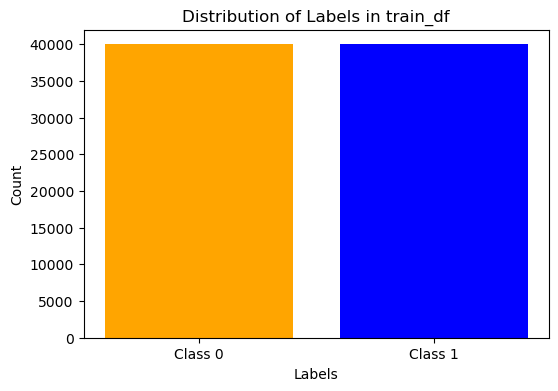

In [24]:
label_counts = train_df['label'].value_counts()
plt.figure(figsize=(6, 4))
plt.bar(label_counts.index, label_counts.values, color=['blue', 'orange']) 
plt.xticks([0, 1], ['Class 0', 'Class 1']) 
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels in train_df')
plt.show()


10. The data is perfectly seperated with even instances for class 0 and class 1.
11. Now let's see one instance from both classes to understand what we are dealing with and which class is AI generated images and which is real images

In [27]:
label_images = train_df.groupby('label').first()['file_name']
train_images_path = 'train_data'

12. Let's define a function to plot the images,

In [30]:
def plot_images(image_paths, labels, title="Label Examples"):
    """
    Plot a series of images with their corresponding labels.

    Args:
        image_paths (list of str): List of file paths to the images to be displayed.
        labels (list of int or str): List of labels corresponding to each image.
        title (str, optional): Title of the entire plot. Default is "Label Examples".

    Returns:
        None: The function displays a matplotlib plot but does not return anything.

    Example:
        image_paths = ["path/to/image1.jpg", "path/to/image2.jpg"]
        labels = [0, 1]
        plot_images(image_paths, labels, title="Sample Images")
    """
    plt.figure(figsize=(10, 5))
    for idx, (img_path, label) in enumerate(zip(image_paths, labels)):
        img = Image.open(img_path)
        plt.subplot(1, len(labels), idx + 1)
        plt.imshow(img)
        plt.title(f"Label {label}")
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


In [32]:
image_paths = [os.path.join(train_images_path, img) for img in label_images]
labels = label_images.index.tolist()

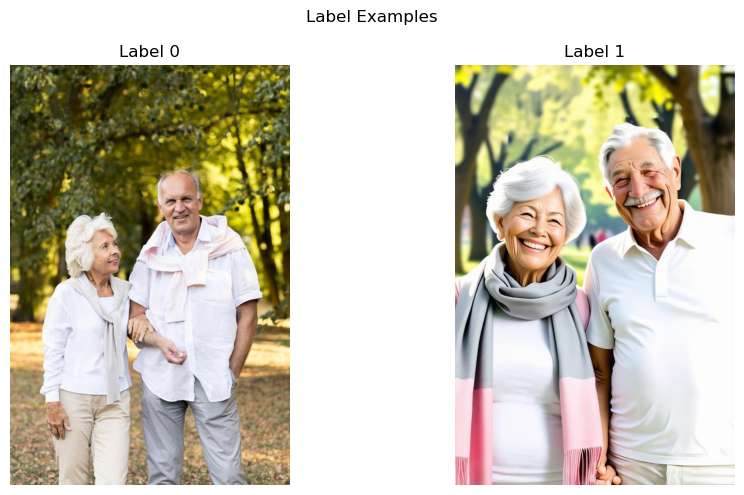

In [34]:
plot_images(image_paths, labels)

13. As it can be seen, or maybe not for everybody. The picture under label 0 is the real image. But why?
14. The obvious hints Label 1 is AI generated are:
- The overly smooth skin and details: AI often struggles with capturing realistic skin aging details, such as natural wrinkles or subtle blemishes. The skin is too smooth.
- Symmetry and unrealistic perfection: AI images may exhibit unnaturally perfect facial symmetry or expressions that look slightly exaggerated, such as overly bright smiles or perfectly aligned teeth.
- Background Details: The background elements (e.g., trees and lighting in this image) might appear slightly inconsistent or blurry, especially where the foreground and background meet. AI sometimes generates repetitive or strange patterns in the background when creating scenes.
- Clothing and Accessories: AI-generated scarves, shirts, or other clothing may have unnatural folds or textures. Look for inconsistencies, such as strange shadows or unrealistic interactions with light.
- Eye and Hair Details: Eyes may look overly sharp or glassy, and the reflections within them might not match the surrounding environment. Hair strands can appear too perfect or lack the natural messiness of real hair.
- Hands and Fingers: While this image appears focused on faces, hands and fingers in AI-generated images are often distorted, with unusual proportions or extra/missing fingers.
- General Vibe: The image might feel too staged or "perfect," almost like a stock photo but slightly off in a way that's hard to describe.

15. This dataset is structured so that every real image has it's AI generated counterpart. The csv file contains the label for the images. The idea is to train a model to be able to find the differences between AI and real image

## **4.Model training(ResNet50, EfficientNet-b0, ConvNeXt**

I will write a script for training models on the data, which would include custom pytorch dataset, data preparation and loading, early stopping, function to continue training from the last best epoch, Tensorboard logging of metrics. I will also try to utilize it with GPU so that it's more time efficient. All models (Convnext-tiny, Efficientnet-b0 and ResNet50 have input size of 224x224). For this project I will run the data without much augmentations to see how they work on a fairly distributed dataset, which is supposed to have good quality images and a fair number of them 40k per class. If I see that the models focus on irrelevant spots or achieve bad performance I will perform more augmentations and modify them(but that is for future work).

Note: All models are trained using the same augmentations and batch size, difference between ResNet, EfficientNet and ConvNeXt come with the learning rate and weight decay (especially for EfficientNet)

### **I. Model training script**

#### **1. ImageDataset - Custom PyTorch Dataset**
- Loads image file names and labels from a CSV file.
- Reads images from the specified directory.
- Applies **optional transformations** (resize, normalization, data augmentation).
- Returns an image tensor and its corresponding label for training.


#### **2. EarlyStopping - Monitors Validation Loss**
- **Tracks validation loss** and stops training if no improvement after `patience` epochs.
- **Saves the best model checkpoint** whenever validation loss improves.
- **Prevents overfitting** by stopping training early if the model starts degrading.


#### **3. Data Preparation - Loading & Splitting Data**
- Reads the dataset from **train.csv** and processes image paths.
- **Splits into 80% training / 20% validation**, maintaining class balance.
- **Applies transformations:**
  - **Training:** Resize, Random Flipping/Rotation (Augmentation), Normalize.
  - **Validation:** Resize, Normalize (No Augmentation).


#### **4. Data Loaders - Efficient Data Handling**
- Converts datasets into **PyTorch DataLoaders** for batch processing.
- **Shuffles training data** for randomness, keeps validation order unchanged.
- Uses `pin_memory=True` for efficient **GPU data loading**.


#### **5. Model Setup - ResNet50 for Binary Classification**
- Loads a **pre-trained ResNet50 model** (`torchvision.models.resnet50()`).
- **Replaces the final layer** to output a **single neuron** (binary classification).
- Moves the model to **GPU (if available)**.
- **Loss Function:** `BCEWithLogitsLoss()` (for binary classification).
- **Optimizer:** `Adam(lr=1e-4)` (adaptive learning rate).


#### **6. load_checkpoint - Resume Training**
- **Loads model weights and optimizer state** from the last checkpoint (`best_model.pth`).
- **Restores training progress** (epoch number & best validation loss).
- **Starts fresh if no checkpoint is found**.

#### **7. train_one_epoch - Training Process**
- Runs a **full training loop** through the dataset.
- Uses **mixed precision (`autocast()`)** for faster GPU training.
- Computes loss, performs **backpropagation**, and updates weights.
- Logs training loss to **TensorBoard**.

#### **8. validate - Model Evaluation**
- **Runs validation without updating weights** (`model.eval()`).
- Computes **loss & key metrics**:  
  - **Accuracy, Precision, Recall, F1-score, AUC** (Area Under Curve).
- Converts model outputs to **binary predictions**.
- Logs validation metrics to **TensorBoard**.

#### **9. Main Training Loop - Full Training Process**
- **Runs for multiple epochs**, training and validating at each step.
- **Saves the best model** whenever validation loss improves.
- **Stops training early** if no improvement (EarlyStopping).
- Logs **loss & performance metrics** to a CSV file.

In [ ]:
# class ImageDataset(Dataset):
#     """
#     A custom PyTorch Dataset class for loading image data and labels from a CSV file.

#     Attributes:
#         annotations (DataFrame): A DataFrame containing image file names and labels.
#         img_dir (str): The directory where image files are stored.
#         transform (callable, optional): Optional transform to be applied on a sample.
#     """
    
#     def __init__(self, csv_file, img_dir, transform=None):
#         """
#         Initializes the ImageDataset.

#         Args:
#             csv_file (DataFrame): DataFrame containing image file names and labels.
#             img_dir (str): Path to the directory containing image files.
#             transform (callable, optional): Transformations to apply to the images.
#         """
#         self.annotations = csv_file
#         self.img_dir = img_dir
#         self.transform = transform

#     def __len__(self):
#         """
#         Returns the total number of samples in the dataset.

#         Returns:
#             int: Number of samples in the dataset.
#         """
#         return len(self.annotations)

#     def __getitem__(self, idx):
#         """
#         Loads and returns an image and its corresponding label at a given index.

#         Args:
#             idx (int): Index of the sample to retrieve.

#         Returns:
#             tuple: (image, label) where image is a transformed PIL image, and label is a tensor.
#         """
#         # Construct full image path
#         img_path = os.path.join(self.img_dir, self.annotations.iloc[idx, 0])
        
#         # Load image and convert to RGB format
#         image = Image.open(img_path).convert("RGB")
        
#         # Convert label to tensor
#         label = torch.tensor(int(self.annotations.iloc[idx, 1]))

#         # Apply transformations if provided
#         if self.transform:
#             image = self.transform(image)

#         return image, label




# class EarlyStopping:
#     """
#     Implements early stopping to terminate training when the validation loss stops improving.

#     Attributes:
#         patience (int): Number of epochs to wait before stopping after no improvement.
#         verbose (bool): If True, prints messages when an improvement is detected.
#         counter (int): Tracks the number of consecutive epochs without improvement.
#         best_loss (float or None): Best recorded validation loss.
#         early_stop (bool): Flag indicating whether early stopping has been triggered.
#     """

#     def __init__(self, patience=5, verbose=True):
#         """
#         Initializes the EarlyStopping mechanism.

#         Args:
#             patience (int): Number of epochs to wait before stopping after no improvement.
#             verbose (bool): Whether to print updates when early stopping is triggered.
#         """
#         self.patience = patience
#         self.verbose = verbose
#         self.counter = 0
#         self.best_loss = None
#         self.early_stop = False

#     def __call__(self, val_loss, model, optimizer, epoch, path="best_model.pth"):
#         """
#         Checks validation loss and determines whether to stop training.

#         Args:
#             val_loss (float): Current validation loss.
#             model (torch.nn.Module): The model being trained.
#             optimizer (torch.optim.Optimizer): Optimizer used for training.
#             epoch (int): Current epoch number.
#             path (str): File path to save the best model checkpoint.

#         Saves the model if validation loss improves. Otherwise, increments the counter
#         and triggers early stopping if patience is exceeded.
#         """
#         if self.best_loss is None or val_loss < self.best_loss:
#             # Validation loss improved, save model checkpoint
#             self.best_loss = val_loss
#             self.counter = 0
#             torch.save({
#                 "epoch": epoch,
#                 "model_state_dict": model.state_dict(),
#                 "optimizer_state_dict": optimizer.state_dict(),
#                 "best_loss": self.best_loss
#             }, path)
#             if self.verbose:
#                 print(f"Validation loss improved to {val_loss:.4f}. Checkpoint saved!")
#         else:
#             # No improvement, increment the counter
#             self.counter += 1
#             if self.verbose:
#                 print(f"No improvement. EarlyStopping counter: {self.counter}/{self.patience}")

#             # If counter reaches patience, trigger early stopping
#             if self.counter >= self.patience:
#                 self.early_stop = True



# # --- Data Preparation ---
# csv_path = "train.csv"
# train_df = pd.read_csv(csv_path)
# train_df["file_name"] = train_df["file_name"].str.replace("train_data/", "", regex=False)
# train_df = train_df.drop(columns=["Unnamed: 0"])
# train_df, val_df = train_test_split(
#     train_df, test_size=0.2, stratify=train_df['label'], random_state=42
# )


# # Define transformations for the training set
# train_transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # Resize images to match ResNet50 input size
#     transforms.RandomHorizontalFlip(),  # Apply random horizontal flipping for augmentation
#     transforms.RandomRotation(10),  # Apply random rotation within 10 degrees
#     transforms.ToTensor(),  # Convert image to PyTorch tensor
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize using ImageNet statistics
# ])


# # Define transformations for the validation set (no augmentation)
# val_transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # Resize images to match ResNet50 input size
#     transforms.ToTensor(),  # Convert image to PyTorch tensor
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize using ImageNet statistics
# ])

# img_dir = "train_data"

# # Create dataset instances for training and validation sets
# train_dataset = ImageDataset(train_df, img_dir, transform=train_transform)
# val_dataset = ImageDataset(val_df, img_dir, transform=val_transform)
# batch_size = 64

# # Create DataLoaders for training and validation datasets
# train_loader = DataLoader(
#     train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True
# )

# val_loader = DataLoader(
#     val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True
# )

# # --- Model Setup ---
# # Determine whether to use GPU (CUDA) or fallback to CPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Load pre-trained ResNet50 model with ImageNet weights
# model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# # Get the number of input features of the fully connected (fc) layer
# num_features = model.fc.in_features

# # Replace the fully connected (fc) layer to fit binary classification (single output neuron)
# model.fc = nn.Linear(num_features, 1)

# # Move the model to the appropriate device (GPU or CPU)
# model = model.to(device)

# # Define the loss function (Binary Cross Entropy with Logits, suitable for binary classification)
# criterion = nn.BCEWithLogitsLoss()

# # Define the optimizer (Adam optimizer with a learning rate of 1e-4)
# optimizer = optim.Adam(model.parameters(), lr=1e-4)


# # --- Resume Training ---
# def load_checkpoint(path, model, optimizer):
#     """
#     Loads a saved model checkpoint if available, allowing training to resume.

#     Args:
#         path (str): File path to the checkpoint file.
#         model (torch.nn.Module): Model instance to load weights into.
#         optimizer (torch.optim.Optimizer): Optimizer instance to load state into.

#     Returns:
#         tuple: (start_epoch, best_val_loss)
#             - start_epoch (int): The epoch to resume training from.
#             - best_val_loss (float): The best validation loss recorded so far.
    
#     If no checkpoint is found, it returns 0 for start_epoch and `float("inf")` for best_val_loss.
#     """
#     if os.path.exists(path):
#         checkpoint = torch.load(path)
#         # Restore model state dictionary
#         model.load_state_dict(checkpoint["model_state_dict"])

#         # Restore optimizer state dictionary
#         optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        
#         # Retrieve epoch and best validation loss
#         start_epoch = checkpoint["epoch"] + 1
#         best_val_loss = checkpoint["best_loss"]
        
#         print(f"Resuming from epoch {start_epoch} with best validation loss {best_val_loss:.4f}")
#         return start_epoch, best_val_loss
#     else:
#         print("No checkpoint found. Starting from scratch.")
#         return 0, float("inf")


# # --- Training Function ---
# def train_one_epoch(model, train_loader, criterion, optimizer, device, scaler, writer=None, epoch=None):
#     """
#     Trains the model for one epoch.

#     Args:
#         model (torch.nn.Module): The neural network model.
#         train_loader (DataLoader): DataLoader for the training dataset.
#         criterion (torch.nn.Module): Loss function.
#         optimizer (torch.optim.Optimizer): Optimizer for training.
#         device (torch.device): Device to use for training (CPU or GPU).
#         scaler (torch.cuda.amp.GradScaler): Gradient scaler for mixed precision training.
#         writer (SummaryWriter, optional): TensorBoard writer for logging (default: None).
#         epoch (int, optional): Current epoch number (default: None).

#     Returns:
#         float: The average training loss for the epoch.
#     """
#     model.train()  # Set model to training mode
#     running_loss = 0.0  # Track total loss

#     # Iterate through training data
#     for images, labels in tqdm(train_loader, desc="Training"):
#         images, labels = images.to(device), labels.to(device).float().unsqueeze(1)  # Move data to device

#         optimizer.zero_grad()  # Reset gradients before backward pass

#         # Use mixed precision for forward pass
#         with autocast():
#             outputs = model(images)  # Forward pass
#             loss = criterion(outputs, labels)  # Compute loss

#         # Backward pass with scaled gradients
#         scaler.scale(loss).backward()  # Compute gradients
#         scaler.step(optimizer)  # Update weights
#         scaler.update()  # Adjust scaler for next step

#         # Accumulate loss
#         running_loss += loss.item() * images.size(0)

#     # Compute average loss
#     epoch_loss = running_loss / len(train_loader.dataset)

#     # Log training loss to TensorBoard if writer is provided
#     if writer and epoch is not None:
#         writer.add_scalar("Loss/Train", epoch_loss, epoch)

#     return epoch_loss  # Return the computed loss for the epoch


# def validate(model, val_loader, criterion, device, writer=None, epoch=None):
#     """
#     Evaluates the model on the validation dataset.

#     Args:
#         model (torch.nn.Module): The trained neural network model.
#         val_loader (DataLoader): DataLoader for the validation dataset.
#         criterion (torch.nn.Module): Loss function.
#         device (torch.device): Device to use for validation (CPU or GPU).
#         writer (SummaryWriter, optional): TensorBoard writer for logging (default: None).
#         epoch (int, optional): Current epoch number (default: None).

#     Returns:
#         tuple: (epoch_loss, accuracy, precision, recall, f1, auc)
#             - epoch_loss (float): Average validation loss.
#             - accuracy (float): Validation accuracy.
#             - precision (float): Precision score.
#             - recall (float): Recall score.
#             - f1 (float): F1-score.
#             - auc (float): Area Under the ROC Curve (AUC).
#     """
#     model.eval()  # Set model to evaluation mode
#     running_loss = 0.0  # Track total validation loss
#     all_labels = []  # Store all true labels
#     all_outputs = []  # Store all model outputs

#     # Disable gradient computation for validation
#     with torch.no_grad():
#         for images, labels in tqdm(val_loader, desc="Validation"):
#             images, labels = images.to(device), labels.to(device).float().unsqueeze(1)  # Move data to device

#             # Forward pass
#             outputs = model(images)
#             loss = criterion(outputs, labels)

#             # Accumulate loss
#             running_loss += loss.item() * images.size(0)

#             # Store labels and outputs for metric computation
#             all_labels.append(labels.cpu().numpy())
#             all_outputs.append(outputs.cpu().numpy())

#     # Compute average loss
#     epoch_loss = running_loss / len(val_loader.dataset)

#     # Convert lists to numpy arrays for metric calculation
#     all_labels = np.concatenate(all_labels)
#     all_outputs = torch.sigmoid(torch.tensor(np.concatenate(all_outputs))).numpy()

#     # Compute classification metrics
#     val_preds = (all_outputs > 0.5).astype(int)  # Convert outputs to binary predictions
#     accuracy = accuracy_score(all_labels, val_preds)
#     precision = precision_score(all_labels, val_preds)
#     recall = recall_score(all_labels, val_preds)
#     f1 = f1_score(all_labels, val_preds)
#     auc = roc_auc_score(all_labels, all_outputs)

#     # Log metrics to TensorBoard if writer is provided
#     if writer and epoch is not None:
#         writer.add_scalar("Loss/Validation", epoch_loss, epoch)
#         writer.add_scalar("Metrics/Accuracy", accuracy, epoch)
#         writer.add_scalar("Metrics/Precision", precision, epoch)
#         writer.add_scalar("Metrics/Recall", recall, epoch)
#         writer.add_scalar("Metrics/F1_Score", f1, epoch)
#         writer.add_scalar("Metrics/AUC", auc, epoch)

#     return epoch_loss, accuracy, precision, recall, f1, auc


# # --- Main Training Script ---

# # Define training parameters
# num_epochs = 20  # Total number of epochs
# checkpoint_path = "best_resnet50_2.pth"  # Path to save the best model checkpoint

# start_epoch, best_val_loss = load_checkpoint(checkpoint_path, model, optimizer)

# early_stopping = EarlyStopping(patience=5, verbose=True)

# writer = SummaryWriter(log_dir="runs/experiment_resnet50_2")  # Set up TensorBoard logging

# dummy_input = torch.randn(1, 3, 224, 224).to(device)  # Create a dummy input tensor
# writer.add_graph(model, dummy_input)  # Log the model architecture

# for name, param in model.named_parameters():
#     writer.add_histogram(f"weights_initial/{name}", param, 0)

# metrics_list = []

# scaler = torch.amp.GradScaler(device='cuda')

# # --- Main Training Loop ---
# for epoch in range(start_epoch, num_epochs):
#     print(f"Epoch {epoch+1}/{num_epochs}")

#     train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device, scaler, writer, epoch)

#     val_loss, accuracy, precision, recall, f1, auc = validate(model, val_loader, criterion, device, writer, epoch)

#     metrics_list.append({
#         "epoch": epoch,
#         "train_loss": train_loss,
#         "val_loss": val_loss,
#         "accuracy": accuracy,
#         "precision": precision,
#         "recall": recall,
#         "f1_score": f1,
#         "auc": auc,
#     })

#     writer.add_scalar("Loss/Train", train_loss, epoch)
#     writer.add_scalar("Loss/Validation", val_loss, epoch)
#     writer.add_scalar("Metrics/Accuracy", accuracy, epoch)
#     writer.add_scalar("Metrics/Precision", precision, epoch)
#     writer.add_scalar("Metrics/Recall", recall, epoch)
#     writer.add_scalar("Metrics/F1_Score", f1, epoch)
#     writer.add_scalar("Metrics/AUC", auc, epoch)

#     current_lr = optimizer.param_groups[0]['lr']
#     writer.add_scalar("Learning_Rate", current_lr, epoch)

#     for name, param in model.named_parameters():
#         writer.add_histogram(f"weights/{name}", param, epoch)

#     print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
#           f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, "
#           f"F1-score: {f1:.4f}, AUC: {auc:.4f}")

#     early_stopping(val_loss, model, optimizer, epoch, path=checkpoint_path)
#     if early_stopping.early_stop:
#         print("Early stopping triggered!")
#         break


# metrics_df = pd.DataFrame(metrics_list)
# metrics_df.to_csv("training_metrics_resnet50.csv", index=False)
# print("Saved training metrics to 'training_metrics_resnet50.csv'")

# writer.close()

# print("Training Complete.")

### **II. Loss plotting function**
I will define a function that reads a CSV file containing training metrics and plots a graph comparing training loss and validation loss over epochs, while also plotting a table with all the metrics of all epochs to compare. 

In [36]:
def show_model_metrics(csv_file, model_name="Model"):
    """
    Loads and displays training metrics from a CSV file.

    Args:
        csv_file (str): Path to the CSV file containing the model metrics.
        model_name (str): Name of the model (for display purposes).
    
    Returns:
        None
    """
    try:
        # Load the CSV file
        metrics_df = pd.read_csv(csv_file)
        
        # Display the table
        print(f"{model_name} Training Metrics:")
        display(metrics_df)

        # Plot Loss Curve if loss columns exist
        if "epoch" in metrics_df.columns and "Loss/Train" in metrics_df.columns and "Loss/Validation" in metrics_df.columns:
            plt.figure(figsize=(8,5))
            plt.plot(metrics_df["epoch"], metrics_df["Loss/Train"], label="Train Loss", marker="o")
            plt.plot(metrics_df["epoch"], metrics_df["Loss/Validation"], label="Validation Loss", marker="s")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title(f"{model_name} - Loss Curve")
            plt.legend()
            plt.grid(True)
            plt.show()
        else:
            print("No loss data found to plot.")

    except Exception as e:
        print(f"Error loading {csv_file}: {e}")

### **III. Information and results for models(ResNet50)**

#### **1. Explanation of ResNet50**

ResNet-50 (Residual Network-50) is a deep convolutional neural network (CNN) designed for image classification and computer vision tasks. It was introduced in the 2015 paper "Deep Residual Learning for Image Recognition" by (He et al., 2015)[14]. and has since become one of the most widely used deep learning architectures.

ResNet-50 is a 50-layer deep network, built with residual learning and skip connections to allow training of very deep models while avoiding common problems like vanishing gradients. The architecture is efficient, achieving high accuracy with fewer parameters compared to older mod- (Potrombia et al., 2025) []

The core innovation of ResNet is the use of residual learning through skip connections, which allow models to effectively train networks with substantially increased depth19.

*1. Problems that ResNets tackle are:*

Vanishing Gradient Problem – As networks get deeper, the gradients used to update weights during backpropagation become too small, preventing effective learning.

Degradation PAs neural networks deepen, they often encounter the degradation problem, where adding more layers leads to higher training error, contrary to expectations. This issue arises not from overfitting but from difficulties in optimizing deeper networks.low ones.

*2. Residual Learning*

ResNet introduced the concept of residual learning, which means instead of learning a function H(x), the network learns the difference (residual function F(x)):

Instead of learning a direct mapping H(x) from input to output, 
$$F(x) = H(x) - x$$

ResNet learns a residual function:

$$H(x) = F(x) + x$$

This equation means the network learns how much to change the input rather than learning everything from scratch. This makes learning easier and improves performance.

*3. Skip connections*
Skip connections (shortcut connections) are the key innovation in ResNet-50. Instead of a layer directly transforming an input X into an output H(X), a skip connection adds the input directly to the output:
$$Y = F(X) + X$$

This simple trick ensures information flows efficiently through the network, preventing gradients from disappearing as they backpropagate. It also allows deeper layers to refine features rather than relearning them entirely.

*4. Architecture*

| *Stage* | *Layers* | *Output Shape* |
|-----------|-----------|-----------------|
| *Conv1*  | 7×7 Conv, 64 filters, stride 2 | 112×112×64 |
| *Max Pooling* | 3×3, stride 2 | 56×56×64 |
| *Stage 1* | 1×1, 64 → 3×3, 64 → 1×1, 256 (×3 blocks) | 56×56×256 |
| *Stage 2* | 1×1, 128 → 3×3, 128 → 1×1, 512 (×4 blocks) | 28×28×512 |
| *Stage 3* | 1×1, 256 → 3×3, 256 → 1×1, 1024 (×6 blocks) | 14×14×1024 |
| *Stage 4* | 1×1, 512 → 3×3, 512 → 1×1, 2048 (×3 blocks) | 7×7×2048 |
| *Global Average Pooling* | 1×1 | 1×1×2048 |
| *Fully Connected 






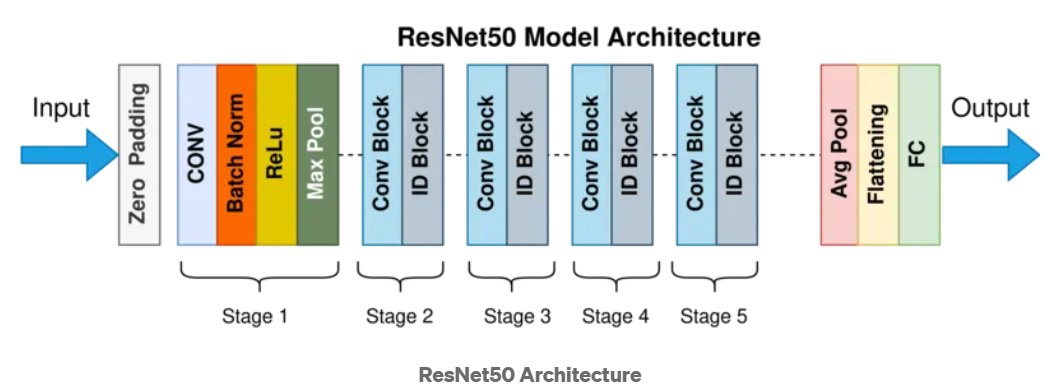




Layer* | Softmax (1000 classes) | 1000 |

- Initial Convolution & Pooling:

The input image first goes through a 7×7 convolutional layer (64 filters, stride 2).
Followed by 3×3 max pooling (stride 2).
This reduces the spatial dimensions while retaining important features.

- Residual Blocks:

Each residual block consists of three layers:
1×1 convolution – Reduces dimensionality.
3×3 convolution – Extracts spatial features.
1×1 convolution – Restores original dimensions.
Skip connections allow gradients to flow more easily through deeper layers.

- Global Average Pooling & Fully Connected Layer:

After the final stage, global average pooling (GAP) is applied.
Followed by a fully conn

The initial stage consists of a convolutional (CONV) layer, batch normalization (Batch Norm), a ReLU activation function, and a max pooling layer to downsample the input. The network is divided into five stages, with each stage comprising residual blocks (Conv Block and ID Block). These blocks utilize skip connections to learn residual mappings, which mitigate the degradation problem in deep networks. The final layers include an average pooling layer, flattening, and a fully connected (FC) layer to produce the output classifications. This design allows ResNet-50 to effectively learn complex features while maintaining computational efficiency.ected (FC) layer with softmax activation for classification.

*5. Bottleneck Residual Blocks*
- ReLU Activation: The ReLU (Rectified Linear Unit) activation function is applied after each convolutional layer and the batch normalization layers. ReLU allows only positive values to pass through, introducing non-linearity into the network, which is e [15]ssential for the network to learn complex patterns in the data.

- Bottleneck Convolution Layers: the block consists of three convolutional layers with batch normalization and ReLU activation after each.:

The first convolutional layer likely uses a filter size of 1x1 and reduces the number of channels in the input data. This dimensionality reduction helps to compress the data and improve computational efficiency without sacrificing too much information.
The second convolutional layer might use a filter size of 3x3 to extract spatial features from the data.
The third convolutional layer again uses a filter size of 1x1 to restore the original numb [15]er of channels before the output is added to the shortcut connection.

*6. Why ResNet would be helpful*
ResNet-50 could work well for the project due to its strong feature extraction, deep learning architecture, and efficiency. It effectively detects textures, patterns, and inconsistencies in AI-generated images. Skip connections and residual learning ensure deep feature learning, while Bottleneck Residual Blocks optimize computation. Proven in face recognition and object detection, it adapts well through transfer learning, making it a highly accura

Load "tensorboard_metrics_resnet50_2_other_combined.csv"te and efficient model for this task.

#### **2. Results from training**

ResNet50 Training Metrics:


,epoch,Loss/Train,Loss/Validation,Metrics/Accuracy,Metrics/Precision,Metrics/Recall,Metrics/F1_Score,Metrics/AUC,Learning_Rate
0,0,0.068074,0.044862,0.983427,0.971456,0.996123,0.983635,0.999261,0.0001
1,1,0.026380,0.028994,0.989994,0.995071,0.984866,0.989942,0.999586,0.0001
2,2,0.021304,0.041499,0.984490,0.982078,0.986992,0.984529,0.998879,0.0001
3,3,0.019123,0.012831,0.995184,0.993887,0.996498,0.995191,0.999887,0.0001
4,4,0.013698,0.037813,0.986742,0.997698,0.975735,0.986594,0.999664,0.0001
5,5,0.014004,0.015105,0.994497,0.991301,0.997749,0.994514,0.999906,0.0001
6,6,0.012227,0.012297,0.996123,0.996495,0.995747,0.996121,0.999890,NaN
7,7,0.011232,0.020816,0.993308,0.991525,0.995122,0.993320,0.999771,NaN
8,8,0.010262,0.037654,0.989493,0.982850,0.996373,0.989565,0.999546,NaN
9,9,0.008743,0.014620,0.994997,0.993392,0.996623,0.995005,0.999875,NaN


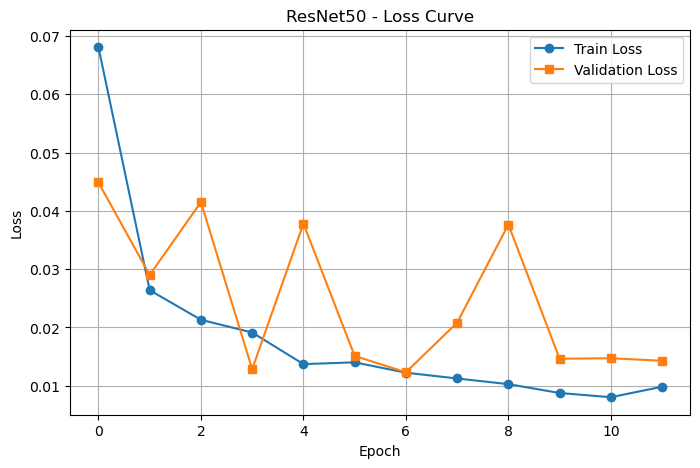

In [40]:
show_model_metrics("tensorboard_metrics_resnet50_2_other_combined.csv", "ResNet50")

1. The training loss consistently decreases across epochs, indicating that the model is learning effectively from the training data. But the validation loss fluctuates significantly, with some epochs showing higher validation loss (e.g., epoch 4 and epoch 8). This is a sign of instability in generalization to unseen data.

2. The accuracy and F1-score metrics are very high throughout the training, reaching values near 0.995 by the later epochs, indicating strong performance in classification. Precision and recall metrics are also close to 1.0, reflecting balanced performance in identifying both classes. The AUC values remain consistently high, above 0.99, across all epochs, demonstrating the model's strong ability to discriminate between positive and negative classes.

3. The training process shows good stability with a steady decrease in training loss. However, the fluctuations in validation loss suggest that the model might not generalize perfectly to unseen data. Despite the high metrics (accuracy, F1-score, AUC), the fluctuations in validation loss suggest that the model might benefit from additional regularization techniques (e.g., dropout, data augmentation) or hyperparameter tuning.

4. The model seems to stabilize in terms of training loss around epoch 6–7. The validation loss, however, suggests instability that persists throughout.

5. The best model was saved on epoch 6, as at epoch 6, the validation loss is low (0.012297) compared to most other epochs. And validation loss starts fluctuating significantly after epoch 6 (e.g., high loss at epoch 8). By choosing epoch 6, you're avoiding a point where the model might have started overfitting to the training data.

6. While the metrics indicate strong classification performance, the fluctuating validation loss suggests that further tuning and regularization may enhance the model's generalization. These refinements will be explored in the future as time is limited now

### **IV. Information and results for models(EfficientNet-b0)**

#### **1. Explanation of EfficientNet-b0**

EfficientNet is a family of convolutional neural networks (CNNs) developed by Google AI researchers in 2019, designed to achieve high performance in image classification tasks while maintaining computational efficiency. The key innovation behind EfficientNet is the introduction of a compound scaling method that uniformly scales the network's depth, width, and resolution using a single compound coefficient. (Tan & Le, 2019) [16]

Traditional CNN scaling methods, like increasing depth in ResNet (e.g., ResNet-18 to ResNet-200), often involve arbitrary choices—depth-wise, width-wise, or resolution scaling—requiring extensive manual tuning with mixed results. EfficientNet introduces a more systematic approach, using compound scaling to optimize depth, width, and resolution simultaneously, achieving superior accuracy and efficiency with fewer resources.

For developing the method of compound scaling, the authors systematically studied the impacts that each scaling technique has on the model’s performance and efficiency. They figured that while scaling single dimensions helps improve model performance, balancing the scale in all the three dimensions — width, depth, and image resolution — considering the variable available resources best improve the overall model performance. The compound scaling method is shown in figure 1 [17]

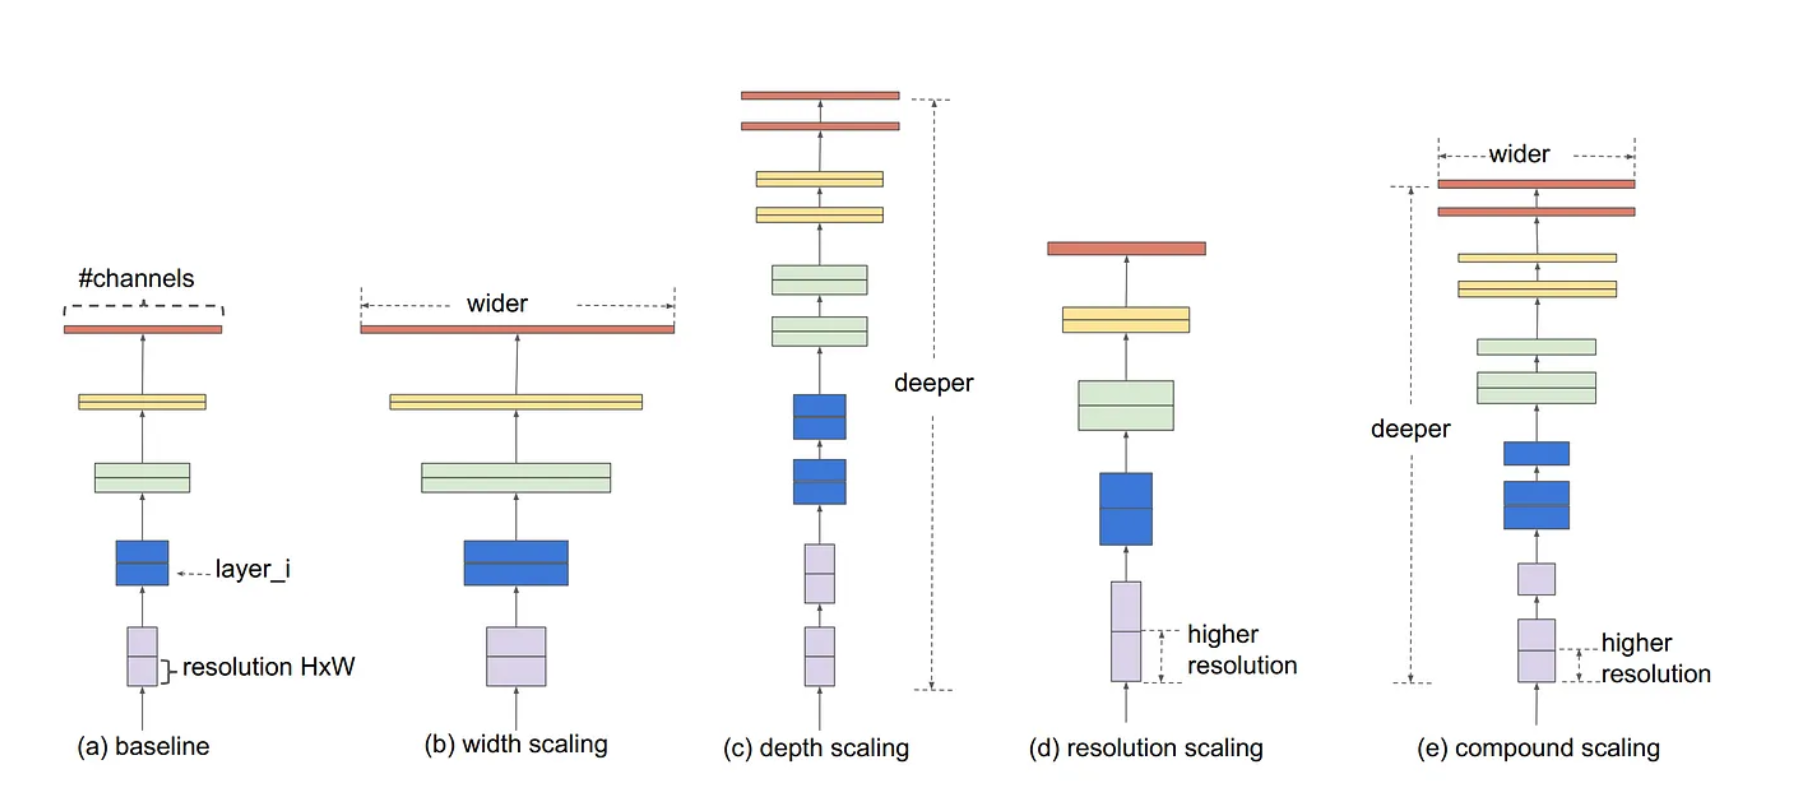 [17]



The compound scaling method is based on the idea of balancing dimensions of width, depth, and resolution by scaling with a constant ratio. The equations below show how it is achieved mathematically,

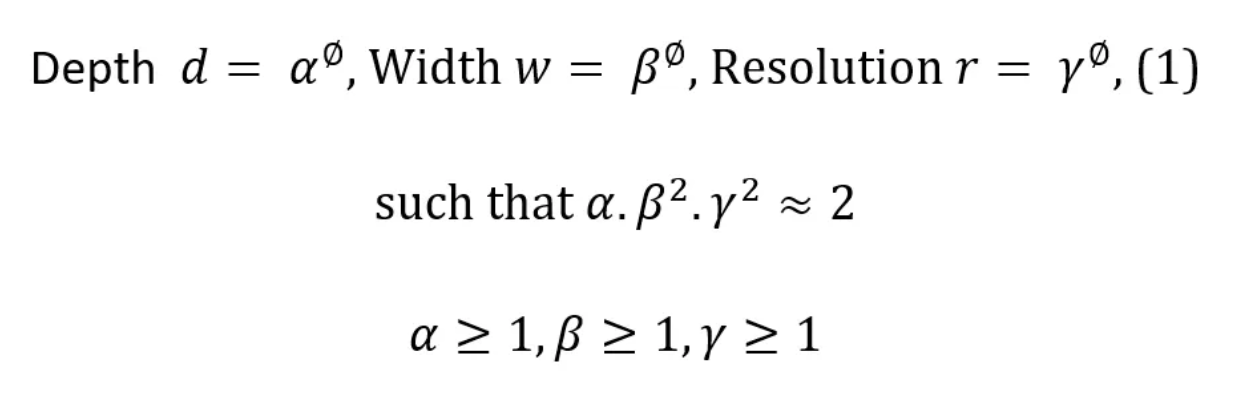 [17]


Value of $\alpha , \beta , \gamma $ are determined using a grid search algorithm. $\phi$ determines the increase in computational resources to the network. This parameter is user defined. They are bound by the factor that denotes that 

$$\alpha \cdot \beta^2 \cdot \gamma^2 \approx 2$$

FLOPS (Floating Point Operations Per Second) of a convolution operation is proportional to $ d \cdot w^2 \cdot r^2 $ which denotes that the FLOPS will double on doubling the network depth. Still, on doubling network width or resolution, the FLOPS will increase four times. In CNNs, the convolutional operations control the computational costs. Scaling the network using the above equation will increase the FLOPS by $(\alpha \cdot \beta^2 \cdot \gamma^2)^ \phi$. Since this is approximately 2, for every new $\phi$ the total FLOPS increase by $2 ^ \phi$

When $\phi$ is set to 1 and assuming twice more resources are available, doing a small grid search gives the values of $\alpha , \beta , \gamma$ , for $\phi = 1$ , the values are $\alpha = 1.2$ , $\beta = 1.1$ , $\gamma = 1.5$ keepin the equation to be approximately 2. This is the EfficientNet-B0 model, which we will be using .

Next values of $\alpha , \beta , \gamma$ are fixed, and the baseline network is scaled up with different values $\phi$ to obtain models EfficientNet B1 to B7. Even better performance might be achieved by searching for $\alpha , \beta , \gamma $ values around the larger model, but then the search cost becomes much higher. Therefore, to solve this issue, the search is done from scratch using a small network.

The intuition for the networks is, if the input image is bigger, then the network needs more layers to increase the receptive field and more channels to capture more fine-grained patterns on the bigger image. The compound scaling technique also helped improve the model efficiency and accuracy of previous CNN models such as MobileNet and ResNet by around 1.4% and 0.7% ImageNet accuracy, respectively, compared to other random scaling methods. [16],[17]

**Architecture**

EfficientNet is based on the baseline network developed by the neural architecture search using the AutoML MNAS framework. The network is fine-tuned for obtaining maximum accuracy but is also penalized if the network is very computationally heavy. It is also penalized for slow inference time when the network takes a lot of time to make predictions. The architecture uses a mobile inverted bottleneck convolution similar to MobileNet V2 but is much larger due to the increase in FLOPS. This baseline model is scaled up to obtain the family of EfficientNets.

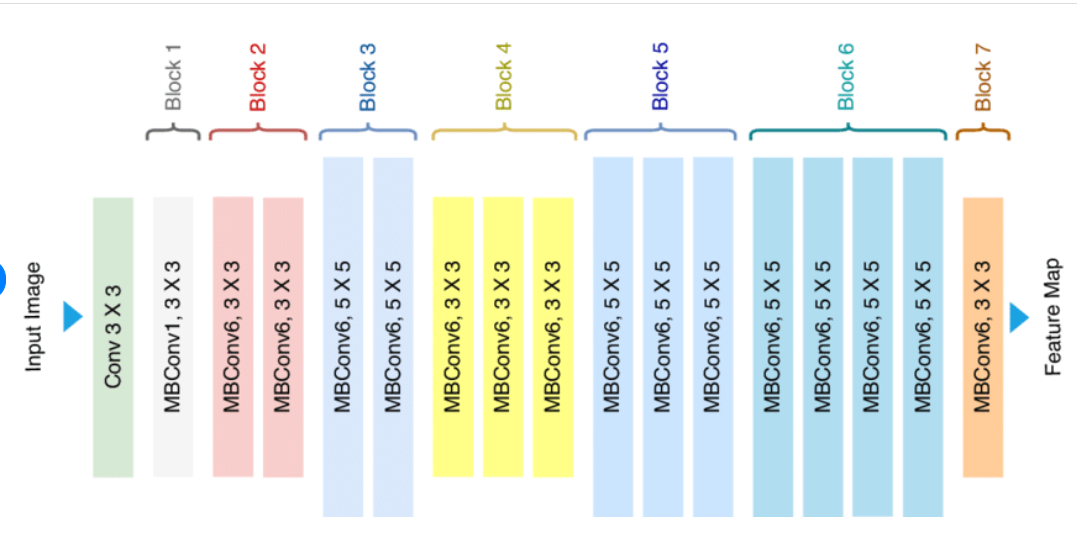   [17]


EfficientNet's architecture starts with an initial 3x3 convolution layer for low-level feature extraction, followed by multiple blocks built with Mobile Inverted Bottleneck Convolutions (MBConv). Each MBConv block includes 
- Depthwise convolution (Applies a single convolutional filter to each input channel, significantly reducing computation.),
- Pointwise convolution ( A 1x1 convolution to combine channel-wise outputs.),
- Squeeze-and-excitation (SE) modules (These adaptively weight feature maps, focusing on important channels while suppressing less relevant ones.), 
- Inverted bottleneck design (Instead of reducing dimensions (as in standard bottlenecks), the input expands to a higher-dimensional space (using an expansion factor, e.g., 6x) and then compresses back to a lower dimension.).
- The architecture is divided into blocks with varying kernel sizes (3x3 or 5x5), strides, and resolutions, scaled systematically using the compound scaling method. Skip connections are used within blocks when input and output dimensions match, improving gradient flow. The final layers include global average pooling, a fully connected layer, and a softmax activation for classification. This design is efficient, scalable, and achieves high accuracy with fewer resources.


**How would EfficientNet be useful for my project**

EfficientNet should work well for classifying AI-generated and real images because of its high accuracy, lightweight architecture, and ability to extract fine-grained features through squeeze-and-excitation modules. Its scalable variants (B0 to B7) allow flexibility to balance performance and computational resources, while its transfer learning capabilities enable efficient adaptation to your specific dataset. EfficientNet's ability to handle varying image resolutions and focus on subtle distinctions makes it effective for detecting artifacts or textures unique to AI-generated images. Additionally, its computational efficiency ensures suitability for both high-performance systems and resource-constrained environments.

**Why EfficientNet-b0**

For this project I will be using EfficientNet-b0 as it's lightweight, easy to compute. If the model doesn't show satisfying performance it will be changed with its bigger variants in the future. 

#### **2. Code changes**

1. The code stays mostly the same as the models take the same input 224x224. I will be using EfficientNet-b0 if I plan on using another variant of it I will have to change it.
2. We will exchange the model and importantly I will try AdamW here(AdamW is an adaptive optimizer that adjusts the learning rate for individual parameters. A small global learning rate works well with AdamW, as the optimizer further fine-tunes updates based on gradients.) And a smaller learning rate and weight_decay (or L2 regularization) that penalizes large weights and helps prevent overfitting. This value is standard and balances regularization with learning speed.

In [ ]:
# model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
# num_features = model.classifier[1].in_features  # Adjust for binary classification
# model.classifier[1] = nn.Linear(num_features, 1)  # Binary classification
# model = model.to(device)

# criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)

3. Change the paths to running the tensorboard, saving the csv and

In [ ]:
# checkpoint_path = "best_efficientnet_3.pth"
# writer = SummaryWriter(log_dir="runs/experiment_efficientnet_3")
# metrics_df.to_csv("training_metrics_efficientnet_3.csv", index=False)
# print("Saved training metrics to 'training_metrics_efficientnet_3.csv'")

4. And of course initialise the model

In [ ]:
# from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

#### **3. Results from training**
Load tensorboard_metrics_efficientnet_other_combined.csv

EfficientNet-b0 Training Metrics:


,epoch,Loss/Train,Loss/Validation,Metrics/Accuracy,Metrics/Precision,Metrics/Recall,Metrics/F1_Score,Metrics/AUC,Learning_Rate
0,0,0.116463,0.036422,0.987993,0.992676,0.983240,0.987935,0.999317,0.00005
1,1,0.033401,0.019630,0.994434,0.996234,0.992620,0.994424,0.999730,0.00005
2,2,0.019363,0.015102,0.995310,0.996863,0.993746,0.995302,0.999831,0.00005
3,3,0.012507,0.012123,0.996748,0.998244,0.995247,0.996743,0.999849,0.00005
4,4,0.009474,0.012648,0.995997,0.997866,0.994121,0.995990,0.999844,0.00005
5,5,0.007193,0.011709,0.996435,0.996995,0.995872,0.996433,0.999815,0.00005
6,6,0.005369,0.010304,0.996623,0.996623,0.996623,0.996623,0.999915,0.00005
7,7,0.004496,0.011080,0.996498,0.996746,0.996248,0.996497,0.999821,0.00005
8,8,0.003845,0.009703,0.997123,0.996502,0.997749,0.997125,0.999882,0.00005
9,9,0.003438,0.009645,0.997311,0.997747,0.996873,0.997310,0.999892,0.00005


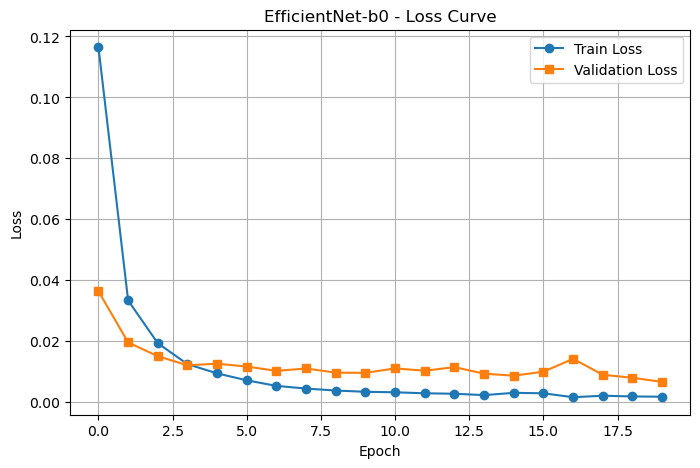

In [43]:
show_model_metrics("tensorboard_metrics_efficientnet_other_combined.csv", "EfficientNet-b0")

1. The training loss shows a steep decline in the first few epochs, which is expected as the model learns quickly during the initial phase.

2. The validation loss also decreases and stabilizes, though it fluctuates slightly after epoch 5. These fluctuations are minor and not concerning.

3. Accuracy, precision, recall, F1 score, and AUC metrics remain consistently high across all epochs, with values exceeding 0.99 from the early epochs.

4. The gap between the training loss and validation loss is small, suggesting there isn’t significant overfitting and The validation loss remains stable even as training progresses, which further supports this conclusion.

5. The loss curves and metrics indicate a stable training process. There is no erratic behavior or sudden spikes in validation loss, which often signal issues like overfitting or data leakage.

6. The slight oscillations in validation loss are normal, particularly for small datasets or complex tasks. These fluctuations are well within acceptable bounds and do not raise concerns.

7. Though minor, the fluctuations in validation loss could indicate room for experimentation with techniques such as early stopping based on difference between train and val loss, not only by best val loss or more aggressive learning rate decay and more epochs as the line looks like its going to converge, but we cannot know for sure

8. The model was saved at the last epoch as it was based on best val loss and the last epoch achieves it.

9. The EfficientNet model shows slightly better precision,recall, f1-score and AUC than ResNet50. The loss curve is much smoother than the ResNet50, but we shouldn't judge ResNet on that, as EfficientNet has much lower Lr and regularization.

### **V. Results for models(ConvNeXt-tiny)** 

#### Some explanations beforehand
1. A Convolutional Neural Network (CNN), or ConvNet, is a deep learning model designed for image processing. It works by using convolutions (small sliding filters) to detect patterns in images, such as edges, shapes, and textures. Applies convolutional layers (filters) to detect patterns, pooling Layers reduce the size of feature maps and Fully Connected Layers make final predictions.
- They have strong local feature extraction (focuses on nearby pixels) and are efficient and fast for image tasks but struggle with long-range dependencies in images.

2. A Vision Transformer (ViT) is a deep learning model that processes images like text using self-attention instead of convolutions. The image is split into small patches (e.g., 16×16 pixels), each patch is converted into a sequence (like words in a sentence), self-Attention learns relationships between patches, even if they are far apart and the model makes predictions using fully connected layers.
- They are good for global feature extraction (learns relationships between distant parts of an image) and performs better on large datasets, but require high computational power

#### **1. Explanation of ConvNeXt-tiny**
**1. What is ConvNeXt**
ConvNeXt is a family of pure convolutional neural networks (ConvNets) introduced to modernize traditional ConvNet architectures by integrating design elements inspired by Vision Transformers (ViTs). This approach aims to enhance performance in image recognition tasks while maintaining the simplicity and efficiency inherent to ConvNets(Liu et al., 2022) [18]. The early 2020s witnessed the emergence of Vision Transformers, which quickly surpassed ConvNets as the state-of-the-art in image classification. However, vanilla ViTs faced challenges in tasks like object detection and semantic segmentation. Hierarchical Transformers, such as Swin Transformers, reintroduced several ConvNet priors, making Transformers more practical as generic vision backbones. This development prompted researchers to reevaluate ConvNet designs to test their limits and potential.(Liu et al., 2022) [18]  (Erdoğan, 2023) [19] (Singh, 2022) [20]

**2. Changes**
ConvNeXt takes the standard ResNet architecture and replaces outdated components with modern features inspired by Swin Transformer and ViTs. Instead of fundamentally changing how CNNs operate, ConvNeXt optimizes existing convolutional designs using the following key changes:

| *Traditional CNNs (ResNet)* | *ConvNeXt (Modern CNN)* |
|-----------|-----------|
| 3×3 standard convolution | 7×7 depthwise separable convolution |
| Batch Normalization (BatchNorm) | Layer Normalization (LayerNorm) | 
| ReLU activation | GELU activation (smoother gradients) | 
| Standard bottleneck blocks| Inverted bottleneck blocks (more efficient) |
| Strided convolution for downsampling | Patchify stem (like Vision Transformers) | 

**3. Architecture**


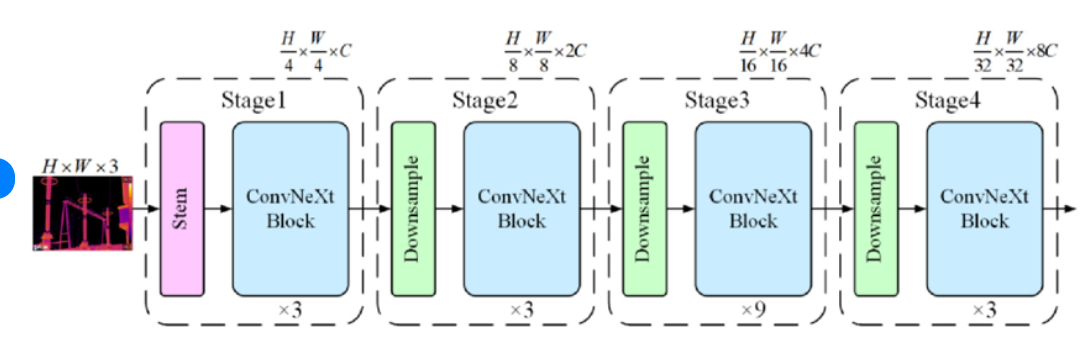 [21]


The ConvNeXt architecture starts by converting the input image into smaller patches using a 4×4 convolution (Stem) to reduce spatial resolution while maintaining essential features. The model then processes these patches through four hierarchical stages, each comprising ConvNeXt Blocks that use modern design elements like 7×7 depthwise convolutions, inverted bottlenecks, LayerNorm, and GELU activations. Between stages, downsampling layers halve the spatial resolution and increase feature channels, enabling the model to capture progressively more abstract and complex features. By the final stage, the spatial resolution is reduced to $\frac{H}{32} X \frac{W}{32}$
and the features are globally pooled before passing through a fully connected layer for classification. This design combines the efficiency of CNNs with innovations inspired by Vision Transformers, making it capable of learning rich hierarchical representations. [18] [19]([20]

ConvNeXt retains the hierarchical structure of CNNs, consisting of four stages where the feature resolution decreases, and the number of channels increases. Each stage consists of ConvNeXt blocks, which are inspired by ResNet bottleneck blocks but modernized for better performance.

- Large 7×7 Depthwise Convolutions : Unlike 3×3 convolutions in ResNet, ConvNeXt uses 7×7 depthwise convolutions to increase the receptive field and capture long-range dependencies, similar to how self-attention in Transformers works.

- Inverted Bottleneck Design : ConvNeXt expands feature dimensions before applying convolutions rather than after. This design reduces computational cost while increasing model expressiveness.

- Layer Normalization Instead of BatchNorm : LayerNorm (LN) normalizes features independently of batch size, making it more stable across different batch sizes. Unlike BatchNorm, which normalizes over batches, LayerNorm is computed across channels, which  makes ConvNeXt more robust and stable $$\hat{x} = \frac{x - \mu_L}{\sigma_L}$$

- Gaussian Error Linear Unit (GELU) activation provides smoother gradients compared to ReLU. Defined as: $$GELU(x) = x \cdot \phi(x)$$ , where $\phi(x)$ is Gaussian cumulative distribution function. GELU is an activation function that is smoother and more mathematically grounded than traditional activation functions like ReLU. It combines the benefits of non-linearity and a probabilistic approach to improve gradient flow during training. Unlike ReLU, which has a sharp cutoff at  x=0, GELU transitions smoothly, improving gradient flow.

 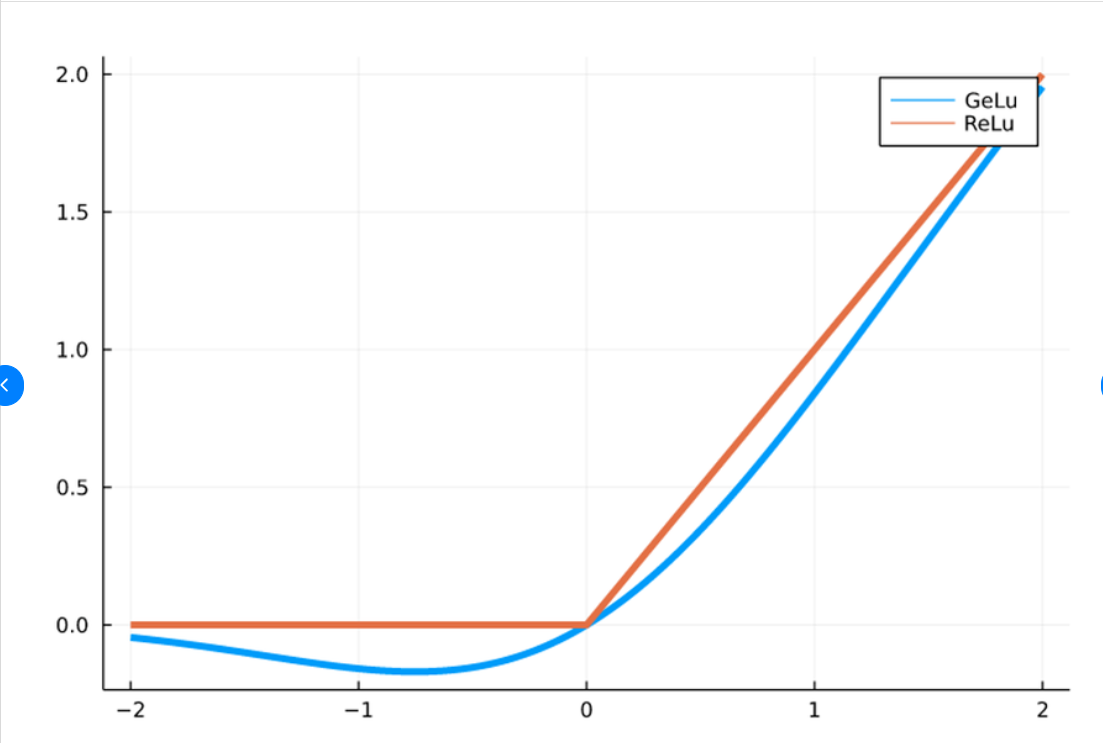 [22]


- Patchify Stem Instead of Strided Convolutions : Inspired by Vision Transformers, ConvNeXt replaces initial convolution layers with a 4×4 patch embedding layer (patchify stem). This improves efficiency while keeping CNN-like hierarchical structure.

**4. How it works**
- Patch Embedding Layer (Patchify Stem) - The input image is converted into patches using a 4×4 convolution with stride 4, similar to ViTs.
- Feature Extraction via ConvNeXt Blocks - The feature map is processed hierarchically in four stages and each stage consists of ConvNeXt blocks that perform: 7×7 depthwise convolutions for spatial feature extraction, inverted bottleneck transformations for computational efficiency, LayerNorm and GELU activation for stability.
- Global Feature Aggregation - After passing through all stages, the feature map undergoes global average pooling to aggregate features.
- Final Classification Layer - A fully connected layer is used for final predictions.

**5. Why ConvNeXt-tiny**
There are different variations of the ConvNeXt(Tiny,Small,Base,Large) based on the parameters, GFLOP's and so on. But I have decided to use the tiny model as it's best for mobile and real-time applications. It's not time expenisve and computationally expensive.

**6. How can it be useful for my project**
ConvNeXt is an efficient and robust model for classifying real and AI-generated images, combining CNN efficiency with Transformer-inspired innovations. Its hierarchical design and features like 7×7 depthwise convolutions, GELU activation, and LayerNorm enable it to capture subtle differences, such as texture or edge inconsistencies, while generalizing well even with smaller datasets.

#### **2. Code difference**

1. Exchanging the model and changing the learning rate and putting weight_decay at 1e-2

In [ ]:
# model = convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
# num_features = model.classifier[2].in_features
# model.classifier[2] = nn.Linear(num_features, 1)  # Adjust for binary classification
# model = model.to(device)

# criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

In [ ]:
# checkpoint_path = "best_convnext_tiny_2.pth"
# writer = SummaryWriter(log_dir="runs/experiment_convnext_tiny_2")
# metrics_df = pd.DataFrame(metrics_list)
# metrics_df.to_csv("training_metrics_convnext_tiny.csv", index=False)
# print("Saved training metrics to 'training_metrics_convnext_tiny.csv'")

In [ ]:
# from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights

#### **3. Results from training**
Load tensorboard_metrics_combined.csv

ConvNeXt-tiny weighted Training Metrics:


,epoch,Loss/Train,Loss/Validation,Metrics/Accuracy,Metrics/Precision,Metrics/Recall,Metrics/F1_Score,Metrics/AUC,Learning_Rate
0,1,0.014182,0.007230,0.997498,0.997747,0.997248,0.997498,0.999970,0.0001
1,2,0.009922,0.007731,0.997061,0.997496,0.996623,0.997059,0.999954,0.0001
2,3,0.008709,0.006737,0.997561,0.996877,0.998249,0.997563,0.999976,0.0001
3,4,0.007211,0.005935,0.997999,0.998123,0.997874,0.997998,0.999983,NaN
4,5,0.007558,0.015850,0.994997,0.997486,0.992495,0.994984,0.999871,NaN
5,6,0.008404,0.021659,0.994059,0.999115,0.988993,0.994029,0.999888,NaN


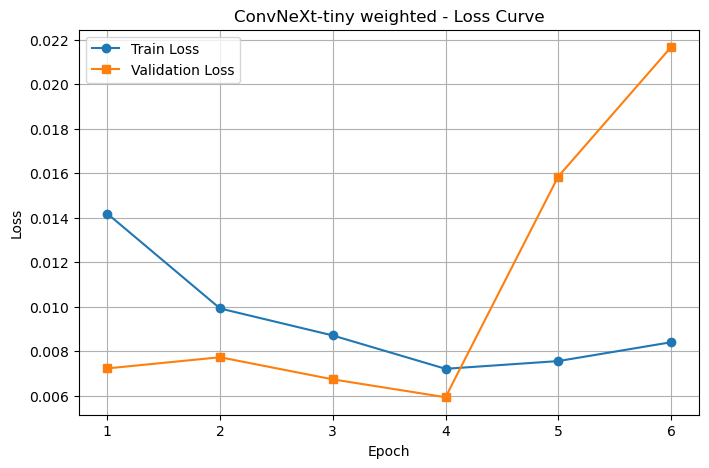

In [45]:
show_model_metrics("tensorboard_metrics_combined.csv", "ConvNeXt-tiny weighted")

1. The metrics seem fine - metrics are consistently above 99.6%, indicating a well-balanced model with minimal false positives (high precision) and false negatives (high recall).
2. Train Loss - Consistently decreases over epochs, showing that the model is learning effectively
3. Validation Loss - Initially decreases but spikes significantly after epoch 4, increasing sharply by epoch 6. This sharp increase suggests overfitting after epoch 4, where the model begins to memorize the training data instead of generalizing to the validation data.
4. And also the validation loss is lower than the train loss meaning that maybe the regularization technique maybe penalizes the training too much, so I will try this model, but wihtout weight decay to see how it performs.
5. This model is well suited for usage

### **VI. Results for models(ConvNeXt-tiny zero weight)** 

#### **1. Difference with previous ConvNeXt-tiny**

The difference is that the weight decay is set to 0. Eveything else is the same.

#### **2. Code difference**

In [ ]:
# optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0)

#### **3. Results from training**
Load tensorboard_metrics_conv_zero_other_combined.csv

ConvNeXt-tiny zero weight Training Metrics:


,epoch,Loss/Train,Loss/Validation,Metrics/Accuracy,Metrics/Precision,Metrics/Recall,Metrics/F1_Score,Metrics/AUC,Learning_Rate
0,0,0.050397,0.013986,0.994872,0.991674,0.998124,0.994888,0.999913,0.0001
1,1,0.018041,0.010471,0.996560,0.997868,0.995247,0.996556,0.999929,0.0001
2,2,0.013010,0.008634,0.997061,0.997247,0.996873,0.997060,0.999951,0.0001
3,3,0.008100,0.017968,0.993496,0.995230,0.991745,0.993484,0.999833,0.0001
4,4,0.010311,0.013581,0.995059,0.996612,0.993496,0.995052,0.999898,0.0001
5,5,0.007126,0.018986,0.994809,0.990575,0.999124,0.994832,0.999897,0.0001
6,6,0.006244,0.008564,0.997498,0.997001,0.997999,0.997500,0.999967,NaN
7,7,0.007384,0.010917,0.996498,0.995135,0.997874,0.996503,0.999935,NaN
8,8,0.005944,0.010223,0.997186,0.995389,0.998999,0.997191,0.999966,NaN
9,9,0.005547,0.010096,0.996936,0.994770,0.999124,0.996942,0.999978,NaN


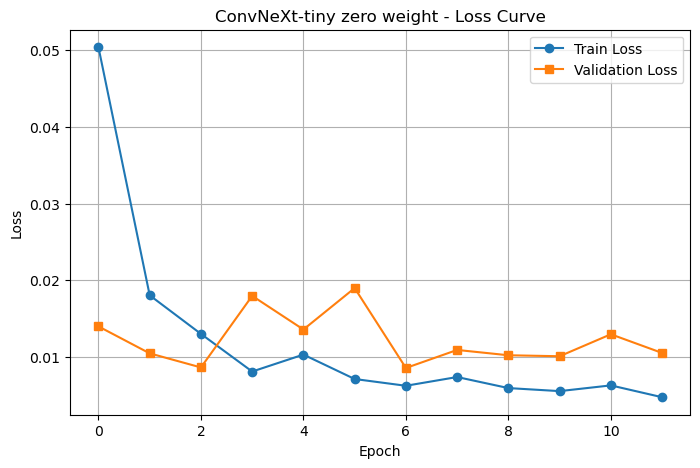

In [47]:
show_model_metrics("tensorboard_metrics_conv_zero_other_combined.csv", "ConvNeXt-tiny zero weight")

1. Accuracy: The model achieves very high accuracy (>99.6%) throughout training, indicating strong classification ability.
2. Precision & Recall: Both precision (99.5-99.9%) and recall (99.5-99.9%) remain consistently high, suggesting the model is effectively distinguishing between classes without major bias.
3. F1 Score: Maintains values close to 0.995, meaning a good balance between precision and recall.
4. AUC Score: Stays around 0.999, meaning the model has near-perfect ability to differentiate between classes.
5. Loss: The train loss continuously decreases in a stable manner, The validation loss fluctuates more compared to training loss but stays relatively low. The gap between training and validation loss is small but inconsistent, indicating good performance but with some potential for noise sensitivity.
6. The model was saved at epoch 6 : The small difference (~0.0023) between train and validation loss suggests the model is well-fitted without memorizing the training data (overfitting). The model has already achieved near-perfect accuracy and AUC at this point.

### **VII. Choosing the model** 

1. Validation Loss Consistency
ConvNeXt: The validation loss curve shows fluctuations but stabilizes quickly, indicating that the model adapts rapidly and avoids severe overfitting. The gap between training and validation loss is small, which is a sign of generalization.
EfficientNet: The validation loss decreases consistently without significant fluctuations, showing a steady improvement. However, the gap between training and validation loss is more noticeable, suggesting potential overfitting.
Advantage: If generalization is a priority (especially for unseen data), ConvNeXt's smaller gap and stabilization may be preferable.

2. Epoch Performance
ConvNeXt achieves stable performance within 6 epochs, which suggests faster convergence.
EfficientNet takes 19 epochs to reach its best state, showing slower convergence but smoother progress.
Advantage: If training time and computational resources are a concern, ConvNeXt may be a better choice due to faster convergence.

3. Loss Curve Behavior
EfficientNet: The curve is smoother, indicating consistent learning, but the training loss is much lower than the validation loss, which could be a warning of overfitting.
ConvNeXt: Despite the noisy validation loss, the training and validation losses are closer, which often implies better model robustness and less reliance on training data.
Advantage: ConvNeXt's closer alignment of training and validation loss could indicate a more realistic representation of its performance on unseen data.

4. Model Metrics
While EfficientNet achieves slightly higher accuracy, precision, and recall across epochs, ConvNeXt’s performance is still very competitive and has better validation loss trends. Metrics are only slightly lower, meaning ConvNeXt still performs excellently in classification tasks.
Advantage: If metric differences are negligible but training efficiency and generalization are prioritized, ConvNeXt can be justified.

5. Efficiency in Training: ConvNeXt converges faster and is less prone to overfitting due to its tighter validation loss.
Generalization: Smaller gaps between training and validation losses suggest better robustness to new data.
Performance Stability: While EfficientNet shows a smooth curve, ConvNeXt manages to stabilize within a fraction of the time, which is important for projects with limited training budgets.
Final Conclusion:
While both models have their strengths, ConvNeXt's quicker convergence, better alignment of training/validation losses, and sufficient performance metrics make it a valid choice, especially if the aim is faster, more resource-efficient training and deployment.

## **5.Model testing**

### **I. Test set** 

1. Lets see what we are working with for testing the v1 test_set

In [49]:
test_df = pd.read_csv("test.csv")
test_df

,id
0,test_data/e25323c62af644fba97afb846261b05b.jpg
1,test_data/63c7596c97d74c1cb6323db1b7380d5e.jpg
2,test_data/0a5eb7abb22b439580836e22d89e8ca1.jpg
3,test_data/371eddabfc1349a08534ce2292c4c4d3.jpg
4,test_data/7280ea6acaa14a52b7218ae36305b218.jpg
...,...
19981,test_data/796cac2f053b4fc1866a81921e1fe3fa.jpg
19982,test_data/789ee13ba9f84e138913e0a9f7d5d93b.jpg
19983,test_data/a77a1a10cac34f98a085e51997227dbd.jpg
19984,test_data/23641fee71b142b288958f4cdd91d001.jpg


Again, here it has the test_data/ in front of the image id, which could be a problem, so I will remove it and work in a clean data

In [52]:
test_df["id"] = test_df["id"].str.replace("test_data/", "", regex=False) 
test_df.to_csv("new_testset.csv", index=False)

In [54]:
new_test_set = pd.read_csv("new_testset.csv")

In [57]:
new_test_set

,id
0,e25323c62af644fba97afb846261b05b.jpg
1,63c7596c97d74c1cb6323db1b7380d5e.jpg
2,0a5eb7abb22b439580836e22d89e8ca1.jpg
3,371eddabfc1349a08534ce2292c4c4d3.jpg
4,7280ea6acaa14a52b7218ae36305b218.jpg
...,...
19981,796cac2f053b4fc1866a81921e1fe3fa.jpg
19982,789ee13ba9f84e138913e0a9f7d5d93b.jpg
19983,a77a1a10cac34f98a085e51997227dbd.jpg
19984,23641fee71b142b288958f4cdd91d001.jpg


In [59]:
new_test_set.columns

Index(['id'], dtype='object')

2. As it can be seen, we have 19986 images(which based on the on the data description I suppose they should be again 50/50 split(every real image has its AI counterpart), but we don't have labels to know for sure)
3. Let's see if there are any duplicates or NaN values so that we can continue onwards

In [62]:
new_test_set.id.duplicated().sum()

0

In [64]:
new_test_set.id.isnull().sum()

0

4. We dont have missing or duplicated id's which is good, but the fact remains we dont have labels for the images so something should be done.

### **II. Test set ground truths not available** 

1. As there aren't ground truths to compare with what my model predictied, i cannot say if my model is accurate, what the precision and recall is. For this matter I will have to manually label images in order to be able to have some ground truths to compare with.

2. In order to do that I will have to find out how many images i need to label in order to evaluate my AI model’s performance with statistical significance.

3. For this I will be using the sample size formula: $$n = \frac{Z^2 \cdot p \cdot (1 - p)}{e^2}$$

Where: 
- $n$ is the required sample size (number of images I need to label).
- $Z$ Z-score corresponding to the confidence level Example: For a 95% confidence level,  Z=1.96
- $p$ is expected proportion of correct classifications (expected model accuracy). If i think that the model will have lets say 80% accuracy, based on the val scores i think yes (p = 0.8)
- $e$ is margin of error (acceptable error in estimation). If i expect 5% margin $e$ will be 0.05

This formula ensures that the number of labeled images is large enough so that your evaluation results (e.g., accuracy, precision, recall) are statistically significant and not just by random chance.
For my situation I calculated I would need around 246 labeled images, but let's see for sure I will adjust it for finite population
$$n_{adjusted} = \frac{n}{1 + \frac{n-1}{N}}$$

Where: 
- $N$ = total number of images I have (19986)
- $n$ = sample size from the first formula

And after calculations I should have around 244 images, which is not much of a difference

4. But now comes the step of labeling the images I will write a code script to get random images from my test data folder using the id's from the csv file. Possibly plot them to me and I will add a response box with a question (Is this Ai or not 0-real, 1-fake). Which could make the process easier and more systemathic.

UNCOMMENT TO TRY OUT

In [ ]:
# # Load CSV
# csv_path = "new_testset.csv"  # Update with the actual CSV file path
# image_folder = "test_data"  # Update with the actual folder containing images
# column_name = "id"  # Update with the column name containing image paths
# response_file = "responses.csv"  # CSV file to store responses

# # Read CSV and extract image paths
# df = pd.read_csv(csv_path)
# image_paths = df[column_name].dropna().tolist()  # Remove NaN values

# # Randomly select 125 image paths
# selected_paths = random.sample(image_paths, min(125, len(image_paths)))  # Ensure we don't exceed available images

# # Load previous responses if they exist
# if os.path.exists(response_file):
#     responses_df = pd.read_csv(response_file)
#     responses = dict(zip(responses_df["file_name"], responses_df["label"]))  # Convert to dictionary
# else:
#     responses = {}

# # Function to display an image and ask the question
# def display_image(image_path):
#     full_path = os.path.join(image_folder, image_path)  # Construct full path
#     if os.path.exists(full_path):
#         image = Image.open(full_path)
#         plt.imshow(image)
#         plt.axis("off")
#         plt.show()
        
#         # Ask user for input
#         response = input("What do you think this image is? (0 = fake, 1 = real) ")
#         responses[image_path] = response  # Save response
#     else:
#         print(f"Image not found: {full_path}")

# # Loop through selected images and display them
# for path in selected_paths:
#     if path not in responses:  # Skip already answered images
#         display_image(path)
        
#         # Save responses after each image to prevent loss on interruption
#         responses_df = pd.DataFrame(list(responses.items()), columns=["file_name", "label"])
#         responses_df.to_csv(response_file, index=False)

#         print(f"Progress saved. Current responses: {len(responses)}")

5. After some time of labelling I labelled 500 images(hopefully right) as even for some images I was puzzled if it's real or not. But the larger number of images, should mean that there could be a little bit increase in the accuracy of my evaluation

### **III. Testing the labeled data** 

1. I will here leave a script for loading the model and data(labeled by me) so that I can evaluate the model. The scipt will also work for the rest of my images which were unlabeled, and any other set i want to test it on
2. LOAD RESPONSES.CSV

In [ ]:
# def load_data(response_file=None, image_folder=None, mode="labeled"):
#     """
#     Load images for evaluation.

#     Parameters:
#         response_file (str, optional): Path to the CSV file with labeled data.
#         image_folder (str): Directory containing images.
#         mode (str): "labeled" for labeled images, "unlabeled" for unlabeled images.

#     Returns:
#         pd.DataFrame: Dataframe with image file names and (optional) labels.
#     """
#     if mode == "labeled":
#         labeled_data = pd.read_csv(response_file)
#         labeled_data["label"] = labeled_data["label"].astype(int)  # Convert labels to integers
#         return labeled_data
#     elif mode == "unlabeled":
#         all_images = set(os.listdir(image_folder))
#         if response_file:
#             labeled_images = set(pd.read_csv(response_file)["file_name"])
#             unlabeled_images = list(all_images - labeled_images)  # Exclude labeled images
#         else:
#             unlabeled_images = list(all_images)  # Use all images if no labeled file is given
#         return pd.DataFrame({"file_name": unlabeled_images})

# def load_model(checkpoint_path, device):
#     """
#     Load a pre-trained ConvNeXt model for binary classification.

#     Parameters:
#         checkpoint_path (str): Path to the trained model checkpoint.
#         device (torch.device): Device to load the model onto (CPU/GPU).

#     Returns:
#         torch.nn.Module: Loaded model in evaluation mode.
#     """
#     model = convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
#     num_features = model.classifier[2].in_features
#     model.classifier[2] = nn.Linear(num_features, 1)  # Adjust for binary classification
#     model = model.to(device)
    
#     checkpoint = torch.load(checkpoint_path, map_location=device)
#     model.load_state_dict(checkpoint["model_state_dict"])
#     model.eval()
#     return model

# def preprocess_image(image_path, transform, device):
#     """
#     Load and preprocess an image for inference.

#     Parameters:
#         image_path (str): Path to the image file.
#         transform (torchvision.transforms.Compose): Transformations to apply.
#         device (torch.device): Device for computation.

#     Returns:
#         torch.Tensor: Preprocessed image tensor.
#     """
#     image = Image.open(image_path).convert("RGB")
#     return transform(image).unsqueeze(0).to(device)

# def run_inference(model, image_tensor):
#     """
#     Run inference on a single image.

#     Parameters:
#         model (torch.nn.Module): Trained PyTorch model.
#         image_tensor (torch.Tensor): Preprocessed image tensor.

#     Returns:
#         tuple: Predicted label (0 or 1) and confidence score.
#     """
#     with torch.no_grad():
#         output = model(image_tensor)
#         prob = torch.sigmoid(output).squeeze().item()
#         return (1 if prob > 0.5 else 0), prob

# def evaluate_or_predict(response_file, image_folder, checkpoint_path, output_file, mode="labeled"):
#     """
#     Evaluate the model on labeled data or predict on unlabeled data.

#     Parameters:
#         response_file (str, optional): Path to CSV with labeled images.
#         image_folder (str): Directory containing test images.
#         checkpoint_path (str): Path to trained model checkpoint.
#         output_file (str): File to save predictions.
#         mode (str): "labeled" for evaluation, "unlabeled" for making predictions.
#     """
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     transform = transforms.Compose([
#         transforms.Resize((224, 224)),  
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ])
    
#     # Load data and model
#     data = load_data(response_file, image_folder, mode)
#     model = load_model(checkpoint_path, device)
    
#     predictions = []
#     for image_path in data["file_name"].tolist():
#         full_path = os.path.join(image_folder, image_path)
#         if not os.path.exists(full_path):
#             print(f"Image not found: {full_path}")
#             continue
        
#         image_tensor = preprocess_image(full_path, transform, device)
#         predicted_label, confidence = run_inference(model, image_tensor)

#         record = {
#             "file_name": image_path,
#             "predicted_label": predicted_label,
#             "confidence": confidence,
#         }

#         if mode == "labeled":
#             record["true_label"] = data[data["file_name"] == image_path]["label"].values[0]

#         predictions.append(record)
    
#     # Save predictions
#     predictions_df = pd.DataFrame(predictions)
#     predictions_df.to_csv(output_file, index=False)
#     print(f"Predictions saved in {output_file}")

#     # If evaluating labeled data, compute performance metrics
#     if mode == "labeled":
#         true_labels = predictions_df["true_label"]
#         predicted_labels = predictions_df["predicted_label"]
#         accuracy = accuracy_score(true_labels, predicted_labels)
#         precision = precision_score(true_labels, predicted_labels)
#         recall = recall_score(true_labels, predicted_labels)
#         f1 = f1_score(true_labels, predicted_labels)

#         print("\n Model Performance Compared to Manual Labels:")
#         print(f"Accuracy: {accuracy:.4f}")
#         print(f"Precision: {precision:.4f}")
#         print(f"Recall: {recall:.4f}")
#         print(f"F1 Score: {f1:.4f}")

# # Example usage: Run on labeled images (evaluate performance)
# evaluate_or_predict(
#     response_file="responses.csv",
#     image_folder="test_data",
#     checkpoint_path="best_convnext_zero.pth",
#     output_file="model_predictions_vs_manual.csv",
#     mode="labeled"
# )

# # # Example usage: Run on unlabeled images (save predictions)
# # evaluate_or_predict(
# #     response_file="responses.csv",
# #     image_folder="test_data",
# #     checkpoint_path="best_convnext_zero.pth",
# #     output_file="model_predictions_unlabeled.csv",
# #     mode="unlabeled"
# # )


### **IV. Results from the labeled data** 

2. The results from this can now be seen and tested, I will utilize a function to show the performance metrics of the model, confusion matrix, the missclasified images and if not many of them are misclassified also plot them and show them

In [66]:
def show_model_performance(csv_file, image_folder=None, display_misclassified=False, max_images=6, images_per_row=3):
    """
    Load model predictions from a CSV file and display evaluation metrics, confusion matrix, and misclassified images.

    Parameters:
        csv_file (str): Path to the CSV file containing 'true_label', 'predicted_label', and 'confidence' columns.
        image_folder (str, optional): Path to the folder containing test images (for displaying misclassified ones).
        display_misclassified (bool): If True, displays misclassified images (only works if image_folder is provided).
        max_images (int): Maximum number of misclassified images to display.
        images_per_row (int): Number of images per row in the misclassified image grid.

    Returns:
        None: Prints metrics, confusion matrix, and optionally displays misclassified images in a grid.
    """
    # Load the CSV file
    df = pd.read_csv(csv_file)

    # Extract true and predicted labels
    true_labels = df["true_label"]
    predicted_labels = df["predicted_label"]

    # Compute evaluation metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    # Display results
    print("\n Model Performance Compared to Manual Labels:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Compute and display confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # Find misclassified images
    if display_misclassified and image_folder:
        misclassified = df[df["true_label"] != df["predicted_label"]]

        if misclassified.empty:
            print("\nNo misclassified images found!")
            return
        
        # Limit to max_images
        misclassified = misclassified.head(max_images)

        print(f"\nShowing up to {min(max_images, len(misclassified))} misclassified images:")

        # Set up grid display
        num_images = len(misclassified)
        rows = (num_images // images_per_row) + (num_images % images_per_row > 0)

        fig, axes = plt.subplots(rows, images_per_row, figsize=(images_per_row * 4, rows * 4))
        axes = axes.flatten()  # Flatten in case of fewer images

        for ax, (_, row) in zip(axes, misclassified.iterrows()):
            image_path = os.path.join(image_folder, row["file_name"])

            if os.path.exists(image_path):
                # Open and display the image
                image = Image.open(image_path)
                ax.imshow(image)
                ax.axis("off")
                ax.set_title(f"True: {row['true_label']}, Pred: {row['predicted_label']}\nConf: {row['confidence']:.4f}")

        # Hide any remaining empty subplots
        for i in range(num_images, len(axes)):
            axes[i].axis("off")

        plt.tight_layout()
        # plt.show()


In [70]:
csv_path = "model_predictions_vs_manual.csv"  # The csv with the results of the model on my labeled data
image_folder_path = "test_data"  # Folder containing test images
show_model_performance(csv_path, image_folder=image_folder_path, display_misclassified=True, max_images=20)

2. Okay so on the labelled data the model performed pretty good, Accuracy: 0.9840 
Precision: 0.984 
Recall: 0.98 1
F1 Score: 0.9. This is a little bit lower than the performance on the validation set, which is good

3. The confusion matrix shows that it correctly classifies most real and fake images (High True Positives and high True Negatives), only 8 from the images were mistaken(4 classified mistakenly as fake and 4 as real). So let's look at the missclassified images844

3. As we can see here, me as an arbiter, is not a great idea, as now i realise i may have misclassified some images myself. I do remember labeling them like that and now that i see the model's prediction i look at the images more in depth and realise that indeed i was wrong. Especially for the image where a hand is holding a plant, there the finger is obviously twisted and not normBut still some of the images bug me out, like the image on the beach and the decorative tree on black background. Overall most of these images were indeed misclassified by me, so the model's performance is still pretty solid
5. But I want to see more images from each label, so that I can judge if it's good or not. I will define a function to plot different images from both classesal. 

In [ ]:
def plot_images_by_predicted_label(csv_file, image_folder, num_images=None):
    """
    Plot images grouped by predicted label with confidence, true label, and predicted label in the title.

    Parameters:
        csv_file (str): Path to the CSV file containing 'true_label', 'predicted_label', and 'confidence' columns.
        image_folder (str): Path to the folder containing test images.
        num_images (int): Number of images to display for each predicted label (default: 10).

    Returns:
        None: Displays images in matplotlib plots.
    """
    # Load predictions CSV
    df = pd.read_csv(csv_file)

    # Filter data by predicted label
    for predicted_label in [0, 1]:
        # Get rows for the current predicted label
        label_df = df[df["predicted_label"] == predicted_label]

        # Randomly sample images (up to num_images)
        sampled_df = label_df.sample(min(num_images, len(label_df)), random_state=42)

        # Setup grid for displaying images
        num_samples = len(sampled_df)
        cols = 5
        rows = (num_samples // cols) + (num_samples % cols > 0)
        fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
        axes = axes.flatten()

        for ax, (_, row) in zip(axes, sampled_df.iterrows()):
            image_path = os.path.join(image_folder, row["file_name"])
            if os.path.exists(image_path):
                # Load and display the image
                image = Image.open(image_path)
                ax.imshow(image)
                ax.axis("off")
                ax.set_title(f"Pred: {row['predicted_label']}, True: {row['true_label']}\nConf: {row['confidence']:.2f}")
            else:
                ax.axis("off")
                ax.set_title("Image not found")

        # Hide any unused axes
        for ax in axes[num_samples:]:
            ax.axis("off")

        # Add a title for the entire grid
        plt.suptitle(f"Images Predicted as {predicted_label}", fontsize=16)
        plt.tight_layout()
        plt.show()

# Example usage
plot_images_by_predicted_label(
    csv_file="model_predictions_vs_manual.csv",
    image_folder="test_data",
    num_images=5
)


7. From what I am seeing the model is doing a good job of classifying real and fake images as the outputs are logical and correct when i look at them. Now its 20 images per class(num_images can be increased to desired )
8. What bothers me is that maybe the model is way too confident as I haven't seen any other confidence than 0 and 1
9. Let's load the predictions file and see what is going on

In [115]:
predicted_manual_values = pd.read_csv("model_predictions_vs_manual.csv")

In [117]:
predicted_manual_values.predicted_label.value_counts()

predicted_label
1    251
0    249
Name: count, dtype: int64

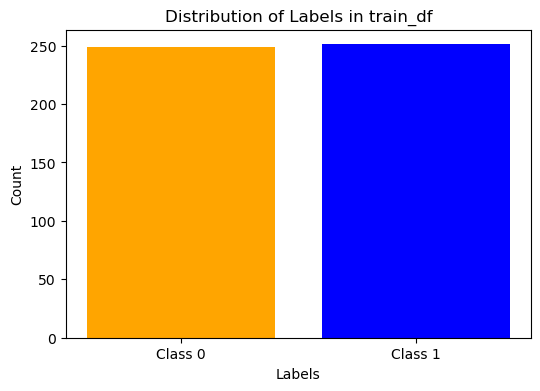

In [119]:
label_counts = predicted_manual_values['predicted_label'].value_counts()
plt.figure(figsize=(6, 4))
plt.bar(label_counts.index, label_counts.values, color=['blue', 'orange']) 
plt.xticks([0, 1], ['Class 0', 'Class 1']) 
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels in train_df')
plt.show()


10. Okay the images have been almost 50/50 classified meaning it doesnt have a bias to one of the classes, and based on what I can see it could be correct
11. Let's see the confidence distribution

In [ ]:
plt.figure(figsize=(7, 5))
plt.hist(predicted_manual_values["confidence"], bins=20, color="blue", alpha=0.7)
plt.xlabel("Confidence Score")
plt.ylabel("Number of Images")
plt.title("Distribution of Model Confidence Scores")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

12. What really worries me is the overconfidence of the model like there aren't any middle or non completely confident results(it's either 0 or 1)
13. I want to see how the model works, how does it decide what is fake or not, what it looks for, then I will also run it on the rest of the data, and probably download the new test set to try it out there. What concerns me is that maybe the test data is too similar to the training data and now my model is just purely overfitting.

### **V. Grad-cam testing on labeled images** 

#### **What is Grad-cam**

Grad-CAM (Gradient-weighted Class Activation Mapping) is a visual explanation technique used to understand which parts of an image influenced a deep learning model's decision. It is widely used in convolutional neural networks (CNNs) to interpret image classification, object detection, and segmentation models. (Selvaraju et al., 2019b) [23]

Grad-CAM works by analyzing the gradients flowing into the last convolutional layer of a CNN to highlight important regions in an image. Here’s the process:
1. Forward Pass (Make Prediction) - The input image is passed through the CNN, and the feature maps (activations) are extracted and the model makes a prediction.
2. Backward Pass (Compute Gradients) - Instead of normal backpropagation (used for training), Grad-CAM calculates gradients of the predicted class score with respect to the feature maps in the last convolutional layer. These gradients tell us how much each spatial location in the feature maps influenced the model's prediction.
3. Generate Heatmap: The gradients are pooled (averaged) over all pixels to get importance weights for each feature map. The feature maps are weighted by these importance values and summed up to get a final heatmap and the heatmap is passed through ReLU activation to remove negative values (only keeping important positive activations).
4. Overlay on Original Image : The heatmap is resized to match the input image size. It is then superimposed on the original image to highlight the regions that most influenced the decision.


#### **Code for Grad-cam**
1. I will write a script to run Grad-Cam, which preprocesses the image, then generates grad cam and overlays it on the original image. The image for it will be taken from the csv file

In [ ]:
def preprocess_image_inference_grad(image_path, transform):
    """Preprocess an image for model inference."""
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return input_tensor, image

def generate_grad_cam(model, input_tensor, target_class=None):
    """Generate Grad-CAM for a given input image and model."""
    gradients = []
    activations = []

    # Define hooks
    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def forward_hook(module, input, output):
        activations.append(output)

    # Register hooks on the last convolutional layer
    last_conv_layer = model.features[-1]
    forward_hook_handle = last_conv_layer.register_forward_hook(forward_hook)
    backward_hook_handle = last_conv_layer.register_full_backward_hook(backward_hook)

    # Run forward pass
    output = model(input_tensor)
    if target_class is None:
        target_class = output.argmax(dim=1).item()
    target_score = output[0, target_class]

    # Run backward pass
    model.zero_grad()
    target_score.backward()

    # Remove hooks
    forward_hook_handle.remove()
    backward_hook_handle.remove()

    # Process gradients and activations
    gradients = gradients[0].cpu().numpy()
    activations = activations[0].cpu().detach().numpy()

    # Compute Grad-CAM
    weights = np.mean(gradients, axis=(2, 3))  
    cam = np.sum(weights[:, :, np.newaxis, np.newaxis] * activations, axis=1).squeeze()
    cam = np.maximum(cam, 0)  
    cam = cam / np.max(cam)  
    return cam

def overlay_grad_cam(image, cam, alpha=0.5):
    """Overlay the Grad-CAM heatmap on the original image."""
    cam_resized = Image.fromarray(np.uint8(cam * 255)).resize(image.size, Image.BILINEAR)
    cam_colored = plt.cm.jet(np.array(cam_resized) / 255.0)[:, :, :3]
    cam_colored = Image.fromarray((cam_colored * 255).astype(np.uint8))
    overlay = Image.blend(image, cam_colored, alpha)
    return overlay

def plot_grad_cam_from_csv(csv_file, image_folder, model, num_images=5, transform=None, confidence_range=None, random_state=None):
    """Process images from a CSV file and plot Grad-CAM results."""
    df = pd.read_csv(csv_file)

    # Apply confidence range filtering
    if confidence_range:
        low, high = confidence_range
        df = df[(df["confidence"] >= low) & (df["confidence"] <= high)]
        print(f"Filtered {len(df)} images with confidence in range {low} to {high}")

    # If filtered dataset is empty, fallback to random selection
    if df.empty:
        print("No images found in the confidence range. Running on random images instead.")
        df = pd.read_csv(csv_file)

    # Sample images
    sampled_df = df.sample(min(num_images, len(df)), random_state=random_state)

    # Set up plot
    fig, axes = plt.subplots(2, num_images, figsize=(15, 10))
    fig.suptitle("Grad-CAM Visualization", fontsize=16)
    
    for i, (_, row) in enumerate(sampled_df.iterrows()):
        image_path = os.path.join(image_folder, row["file_name"])
        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            continue

        # Preprocess the image
        input_tensor, original_image = preprocess_image_inference_grad(image_path, transform)
        input_tensor = input_tensor.to(next(model.parameters()).device)

        # Generate Grad-CAM
        cam = generate_grad_cam(model, input_tensor)
        overlay_image = overlay_grad_cam(original_image, cam)

        # Plot the original and Grad-CAM overlay
        axes[0, i].imshow(original_image)
        axes[0, i].set_title(f"Pred: {row['predicted_label']}\nConf: {row['confidence']:.2f}")
        axes[0, i].axis("off")

        axes[1, i].imshow(overlay_image)
        axes[1, i].set_title("Grad-CAM")
        axes[1, i].axis("off")

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

# ---- Example Usage ----
if __name__ == "__main__":
    # Configuration
    csv_file = "model_predictions_vs_manual.csv"  # Path to the CSV file
    image_folder = "test_data"  # Path to the folder containing test images
    checkpoint_path = "best_convnext_zero.pth"  # Path to the trained model checkpoint

    # Load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
    num_features = model.classifier[2].in_features
    model.classifier[2] = nn.Linear(num_features, 1)  # Binary classification
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()  

    # Transformations for preprocessing
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Example 1: Run Grad-CAM on random images
    plot_grad_cam_from_csv(
        csv_file=csv_file,
        image_folder=image_folder,
        model=model,
        num_images=5,
        transform=transform,
        confidence_range=None,  # No filtering, just random images
        random_state=6
    )

    # # Example 2: Run Grad-CAM on uncertain images (50%-60% confidence)
    # plot_grad_cam_from_csv(
    #     csv_file=csv_file,
    #     image_folder=image_folder,
    #     model=model,
    #     num_images=5,
    #     transform=transform,
    #     confidence_range=(0.5, 0.6),  # Only process images with confidence between 50-60%
    #     random_state=55
    # )


#### **Grad cam observation**

1. I ran grad cam on different random images with different random state, which can be chosen in the script if there is need to observe other images.  I put images of the exact examples i tested
2. From these i can see is that most of the times it looks at logical and reasonable places, but sometimes (especially for class 1) the model looks on the upper half of the image, which concerns me as if there is something wrong with the model(is it overfitting) or there are some features in the AI images that the human eye cannot perceive and the model sees. AI-generated images may contain unique, subtle, or repetitive patterns (such as gradients, texture anomalies, or color shifts) that are not present in real images. These can often appear in less visually important parts, such as edges or corners.
3. In the images classified as real most of the times it looks at more reasonable spots. But on some AI images (Like the image with the skier, the image with the kitchen knife) it looks on the top part of the image
4. I will run multy-layer grad-cam to see what the model looks for in the different layers and why it aims for the top corner in the last layer and takes it as the most important for its decision

### **Multy-layer grad cam**

#### **What is Multy-layer grad cam**

Multi-Layer Grad-CAM is an extension of the Grad-CAM technique that generates heatmaps from multiple layers of a deep learning model. This allows for a more detailed and hierarchical understanding of the model’s decision-making process. (S. Li et al., 2023) [24]

While standard Grad-CAM focuses on a single convolutional layer, Multi-Layer Grad-CAM extends this idea by computing heatmaps for multiple layers in the network.
It Selects multiple convolutional layers from the model (e.g., early, middle, and late layers), attaches forward and backward hooks to capture activations and gradients from each layer, then it performs a forward pass to compute the model's output. After that it performs a backward pass to compute gradients of the target class with respect to activations and compute Grad-CAM heatmaps for each layer separately. Finally it overlays heatmaps on the input image to visualize feature importance.

#### **Code for Multy-layer grad cam**

1. Here I will write a scirpt to perform multy-layer grad cam, some of the functions remain the same (preprocessing and overlaying)
2. The difference will be that in the hook registration, here I will not only take the last layer, but multiple layers. Also the processing for the activations and gradients wont be only on the last layer, but on multiple layers. The output will be at least 3 layers (cams) where in the grad-cam only it was only one 

In [ ]:
def preprocess_image_inference_grad(image_path, transform):
    """Preprocess an image for model inference."""
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0)  
    return input_tensor, image

def generate_multi_layer_grad_cam(model, input_tensor, layers, target_class=None):
    """Generate Grad-CAM heatmaps for multiple layers in the model."""
    activations = {}
    gradients = {}

    # Define hooks for activations and gradients
    def forward_hook(layer_name):
        def hook(module, input, output):
            activations[layer_name] = output
        return hook

    def backward_hook(layer_name):
        def hook(module, grad_input, grad_output):
            gradients[layer_name] = grad_output[0]
        return hook

    # Register hooks for all specified layers
    hooks = []
    for layer_name, layer in layers.items():
        hooks.append(layer.register_forward_hook(forward_hook(layer_name)))
        hooks.append(layer.register_full_backward_hook(backward_hook(layer_name)))

    # Run forward pass
    output = model(input_tensor)
    if target_class is None:
        target_class = output.argmax(dim=1).item()  
    target_score = output[0, target_class]

    # Run backward pass
    model.zero_grad()
    target_score.backward()

    # Remove hooks
    for hook in hooks:
        hook.remove()

    # Generate Grad-CAM heatmaps
    cam_maps = {}
    for layer_name in activations.keys():
        grads = gradients[layer_name].cpu().numpy()
        acts = activations[layer_name].cpu().detach().numpy()
        weights = np.mean(grads, axis=(2, 3))  
        cam = np.sum(weights[:, :, np.newaxis, np.newaxis] * acts, axis=1).squeeze()
        cam = np.maximum(cam, 0)  
        cam = cam / np.max(cam)  
        cam_maps[layer_name] = cam
    return cam_maps

def overlay_grad_cam(image, cam, alpha=0.5):
    """Overlay the Grad-CAM heatmap on the original image."""
    cam_resized = Image.fromarray(np.uint8(cam * 255)).resize(image.size, Image.BILINEAR)
    cam_colored = plt.cm.jet(np.array(cam_resized) / 255.0)[:, :, :3]  
    cam_colored = Image.fromarray((cam_colored * 255).astype(np.uint8))
    overlay = Image.blend(image, cam_colored, alpha)
    return overlay

def plot_multi_layer_grad_cam_from_csv(csv_file, image_folder, model, layers, num_images=5, transform=None, alpha=0.5, confidence_range=None, random_state=42):
    """
    Automatically process images from a CSV file and plot Multi-Layer Grad-CAM results.
    
    Parameters:
        csv_file (str): Path to the CSV file.
        image_folder (str): Path to the folder containing images.
        model (torch.nn.Module): The trained model.
        layers (dict): Dictionary of layers for Grad-CAM.
        num_images (int): Number of images to visualize.
        transform: Image transformations.
        alpha (float): Transparency of Grad-CAM overlay.
        confidence_range (tuple): (low, high) range for confidence filtering. If None, select randomly.
        random_state (int): Seed for reproducibility.
    """
    # Load the CSV file
    df = pd.read_csv(csv_file)

    # Apply confidence range filtering
    if confidence_range:
        low, high = confidence_range
        df = df[(df["confidence"] >= low) & (df["confidence"] <= high)]
        print(f"Filtered {len(df)} images with confidence in range {low} to {high}")

    # If no uncertain images are found, fallback to random selection
    if df.empty:
        print("No images found in the confidence range. Running on random images instead.")
        df = pd.read_csv(csv_file)

    # Randomly sample images
    sampled_df = df.sample(min(num_images, len(df)), random_state=random_state)

    # Set up the plot grid
    num_layers = len(layers)
    fig, axes = plt.subplots(num_images, num_layers + 1, figsize=(15, 5 * num_images))
    fig.suptitle("Multi-Layer Grad-CAM Visualization", fontsize=16)

    for row_idx, (_, row) in enumerate(sampled_df.iterrows()):
        image_path = os.path.join(image_folder, row["file_name"])
        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            continue

        # Preprocess the image
        input_tensor, original_image = preprocess_image_inference_grad(image_path, transform)
        input_tensor = input_tensor.to(next(model.parameters()).device)

        # Generate Grad-CAM heatmaps for multiple layers
        cam_maps = generate_multi_layer_grad_cam(model, input_tensor, layers)

        # Plot original image
        axes[row_idx, 0].imshow(original_image)
        axes[row_idx, 0].set_title(f"Pred: {row['predicted_label']}\nConf: {row['confidence']:.2f}")
        axes[row_idx, 0].axis("off")

        # Plot Grad-CAM for each layer
        for col_idx, (layer_name, cam) in enumerate(cam_maps.items()):
            overlay_image = overlay_grad_cam(original_image, cam, alpha=alpha)
            axes[row_idx, col_idx + 1].imshow(overlay_image)
            axes[row_idx, col_idx + 1].set_title(layer_name)
            axes[row_idx, col_idx + 1].axis("off")

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

# ---- Example Usage ----
if __name__ == "__main__":
    # Configuration
    csv_file = "model_predictions_vs_manual.csv"  
    image_folder = "test_data"  
    checkpoint_path = "best_convnext_zero.pth"  

    # Load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
    num_features = model.classifier[2].in_features
    model.classifier[2] = nn.Linear(num_features, 1)  
    model.load_state_dict(torch.load(checkpoint_path, map_location=device, weights_only=True)["model_state_dict"])
    model = model.to(device).eval()

    # Specify layers for Grad-CAM
    layers = {
        "Layer 1 (Early)": model.features[0],  
        "Layer 2 (Mid)": model.features[3],   
        "Layer 3 (Late)": model.features[-1]  
    }

    # Transformations for preprocessing
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Example 1: Run Multi-Layer Grad-CAM on random images
    plot_multi_layer_grad_cam_from_csv(
        csv_file=csv_file,
        image_folder=image_folder,
        model=model,
        layers=layers,
        num_images=4,
        transform=transform,
        confidence_range=None,  
        random_state=22
    )

    # # Example 2: Run Multi-Layer Grad-CAM on uncertain images (50%-60% confidence)
    # plot_multi_layer_grad_cam_from_csv(
    #     csv_file=csv_file,
    #     image_folder=image_folder,
    #     model=model,
    #     layers=layers,
    #     num_images=4,
    #     transform=transform,
    #     confidence_range=(0.5, 0.6),  
    #     random_state=55
    # )


3. As it can be seen in early layers it focuses on the edges and textures in all images, then it focuses more on object parts and then in the last layer it focuses on the top half of the image, while also slightly highlighting some relevant parts, which is good but in the end on some images it takes the decision based on something which is up above in the image and there is nothing there that at least i can see. Is it overfitting or is it just finding something there that my eyes cannot see. I will test it on the rest of the images to see how it performs

### **VI. Testing on the rest of the 19486 images** 

#### **Code for testing the unlabeled images**

In [ ]:
# # Example usage: Run on unlabeled images (save predictions)
# evaluate_or_predict(
#     response_file="responses.csv",
#     image_folder="test_data",
#     checkpoint_path="best_convnext_zero.pth",
#     output_file="model_predictions_unlabeled.csv",
#     mode="unlabeled"
# )

#### **Results**

1. Let's load the new csv_file and see what we got

In [72]:
unlabelled_predictions = pd.read_csv("model_predictions_unlabeled.csv")
unlabelled_predictions

,file_name,predicted_label,confidence
0,fcb16c74178a4d50b0b4c8bea5a0e635.jpg,1,0.999969
1,d69f1bcb873647c5b78a0e413ce79868.jpg,1,0.999966
2,957cff3d66c14502a0e5f6061e4a1848.jpg,0,0.000029
3,ed871033bbda46bab545e1377bee8f6b.jpg,1,0.999974
4,392d48cdc7884455a2c69a92ea84723d.jpg,0,0.000025
...,...,...,...
19481,5bf1ab8c01464c3396b2e9737cae6bbf.jpg,1,0.999983
19482,b49f2f4d903f49ffb281ee77c6acde0d.jpg,0,0.000011
19483,d035f6b346014e42a14df1a3f30e1637.jpg,0,0.000073
19484,6d6648d3748f4cd4984c9dc58a4fd542.jpg,0,0.000107


2. Let's see the distribution of labels, and the distribution of the confidences.

In [74]:
unlabelled_predictions.predicted_label.value_counts()

predicted_label
1    9773
0    9713
Name: count, dtype: int64

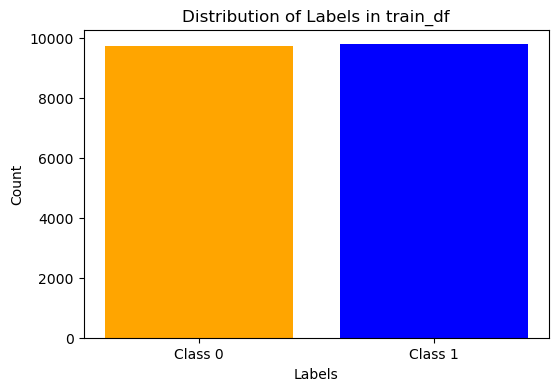

In [76]:
label_counts = unlabelled_predictions.predicted_label.value_counts()
plt.figure(figsize=(6, 4))
plt.bar(label_counts.index, label_counts.values, color=['blue', 'orange']) 
plt.xticks([0, 1], ['Class 0', 'Class 1']) 
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels in train_df')
plt.show()


3. Well the labels seem somewhat evenly distributed, one class is not that much bigger than the other, which could be good, as from the dataset description I suppose the test set is also evenly split 50/50, but here it will be harder to guess as we have no ground truths so plotting images to see what happenned will be the best and grad cam visualisation to see what the model thinks.
4. Let's see the confidences, are they still extreme

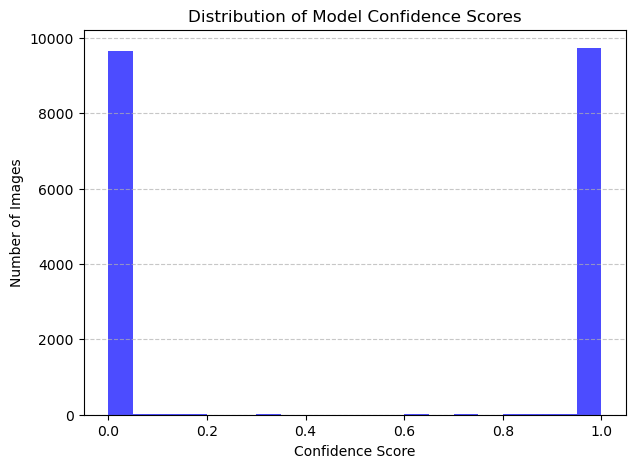

In [78]:
plt.figure(figsize=(7, 5))
plt.hist(unlabelled_predictions["confidence"], bins=20, color="blue", alpha=0.7)
plt.xlabel("Confidence Score")
plt.ylabel("Number of Images")
plt.title("Distribution of Model Confidence Scores")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

5. Again it's extremely sure about the predictions, there are some minimal uncertain ones, but still. I should visualise the images to see what it does. I will run a script to plot a randum number of images 

#### **Image visualisation**

In [ ]:
# ---- CONFIG ----
csv_file = "model_predictions_unlabeled.csv"  # Path to predictions CSV
image_folder = "test_data"  # Path to image folder
num_images = 5  # Number of images to display per category
confidence_threshold = 0.5  # Threshold for ambiguous cases

# ---- LOAD DATA ----
df_unl = pd.read_csv(csv_file)

# ---- FILTER DATA ----
# Randomly select 20 images predicted as each class (0 or 1)
class_1_df = df_unl[df_unl["predicted_label"] == 1].sample(num_images, random_state=42)
class_0_df = df_unl[df_unl["predicted_label"] == 0].sample(num_images, random_state=42)

# Select ambiguous images (near 0.5 confidence)
ambiguous_df = df_unl[(df_unl["confidence"] > (confidence_threshold - 0.05)) & 
                       (df_unl["confidence"] < (confidence_threshold + 0.05))]

# ---- PLOT FUNCTION ----
def plot_images_cf(image_df, title, image_folder, num_images_to_plot):
    """
    Plots images with their confidence scores.

    Parameters:
        image_df (pd.DataFrame): DataFrame containing 'file_name', 'predicted_label', and 'confidence'.
        title (str): Title for the plot.
        image_folder (str): Path to the folder containing images.
        num_images_to_plot (int): Number of images to display.
    """
    # Ensure we don't attempt to display more images than available
    image_df = image_df.head(num_images_to_plot)
    num_images = len(image_df)

    # Setup grid for displaying images
    cols = 5
    rows = (num_images // cols) + (num_images % cols > 0)
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
    axes = axes.flatten()  # Flatten axes for easy iteration

    for ax, (_, row) in zip(axes, image_df.iterrows()):
        image_path = os.path.join(image_folder, row["file_name"])
        if os.path.exists(image_path):
            image = Image.open(image_path)
            ax.imshow(image)
            ax.axis("off")
            ax.set_title(f"Label: {row['predicted_label']}\nConf: {row['confidence']:.2f}")
        else:
            ax.axis("off")
            ax.set_title("Image not found")

    # Hide unused subplots
    for ax in axes[num_images:]:
        ax.axis("off")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# ---- NEW FUNCTION TO PLOT UNCERTAIN IMAGES BY CONFIDENCE RANGES ----
def plot_uncertain_images_by_ranges(df_unl, confidence_ranges, num_images, image_folder, title_prefix):
    """
    Plot uncertain predictions across multiple confidence ranges.

    Parameters:
        df_unl (pd.DataFrame): DataFrame containing predictions.
        confidence_ranges (list of tuples): List of confidence ranges (e.g., [(0.2, 0.3), (0.3, 0.4)]).
        num_images (int): Number of images to sample and display per range.
        image_folder (str): Path to the folder containing images.
        title_prefix (str): Prefix for the title of each plot.
    """
    for confidence_range in confidence_ranges:
        low, high = confidence_range

        # Filter predictions within the confidence range
        uncertain_df = df_unl[(df_unl["confidence"] >= low) & (df_unl["confidence"] < high)]

        # Check if there are any uncertain predictions
        if uncertain_df.empty:
            print(f"No predictions found within confidence range {low:.2f} to {high:.2f}.")
            continue

        # Randomly sample uncertain predictions
        sampled_df = uncertain_df.sample(min(num_images, len(uncertain_df)), random_state=None)

        # Plot the sampled uncertain images
        title = f"{title_prefix}: Confidence {low:.2f} to {high:.2f}"
        plot_images_cf(sampled_df, title, image_folder, num_images)

# ---- DISPLAY IMAGES ----
# Plot random images predicted as class 1
plot_images_cf(class_1_df, f"Random {num_images} Images Predicted as Class 1", image_folder, num_images)

# Plot random images predicted as class 0
plot_images_cf(class_0_df, f"Random {num_images} Images Predicted as Class 0", image_folder, num_images)

# Plot ambiguous cases (confidence ~ 0.5)
if not ambiguous_df.empty:
    plot_images_cf(ambiguous_df, "Ambiguous Cases (Confidence ~ 0.5)", image_folder, num_images)
else:
    print("No ambiguous cases with confidence near 0.5 were found.")

# ---- CONFIDENCE RANGE PLOTS ----
confidence_ranges = [(0.1, 0.2), (0.2, 0.3), (0.3, 0.4), (0.4, 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, 0.9)]
plot_uncertain_images_by_ranges(df_unl, confidence_ranges, num_images=10, image_folder=image_folder, title_prefix="Uncertain Predictions")


#### **Evaluation after looking at the images**
1. Most images that the model predicted from those that I saw (I ran 100 images per class, now i left it at 30, so that it doesn't take much space). Of all the images it confidently labels as 1 and 0(100 samples per class) it correctly classifies them I manually went through all. You can change the num_images to your desired number and it will be seen.
2. The ones where it makes mistakes are the ones he is not so certain about, but even there almost half of the images are (maybe on luck) predicted right. This is why i want to see on what it makes the choice

#### **Grad-Cam**
1. I will run Grad-Cam on the images to see what it looks for here, i will use only the main part from the grad-cam script and exhange the csv for the images

In [ ]:
if __name__ == "__main__":
    # Configuration
    csv_file = "model_predictions_unlabeled.csv"  # Path to the CSV file
    image_folder = "test_data"  # Path to the folder containing test images
    checkpoint_path = "best_convnext_zero.pth"  # Path to the trained model checkpoint

    # Load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
    num_features = model.classifier[2].in_features
    model.classifier[2] = nn.Linear(num_features, 1)  # Binary classification
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)

    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()  # Set to evaluation mode
   
    # Transformations for preprocessing
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Plot Grad-CAM for N-number random images from the CSV
plot_grad_cam_from_csv(
        csv_file=csv_file,
        image_folder=image_folder,
        model=model,
        num_images=5,
        transform=transform,
        confidence_range=(0.4, 0.5), 
        random_state=55
    )

2. Again sometimes it looks in the top part of the image looking, not every time but its concerning, maybe there is something in the images that makes the model search always there. This is not entirely bad , but further refinement and maybe different images for training and more augmentations to make the model look more for the center parts of the image could be helpful.
3. In most images it does well, it looks at some relevant spots, where an AI could make mistake and where a real image could be differentiated, but this top part of image focus on some images does seem odd, is it something that cannot be seen or just on some images it cannot find relevant parts and just makes blind decision.
4. I will run one quick Multy-Grad cam again to see why and where it looks in different layers.

#### **Multy-layer Grad-Cam**
1. Again using only the main from the multy-layer grad cam I will run it to see how it makes the decision. I will run it on the images that have it worse to see why (the milk image sample and the disk sample)

In [ ]:
if __name__ == "__main__":
    # Configuration
    csv_file = "model_predictions_unlabeled.csv"  # Path to the CSV file
    image_folder = "test_data"  # Path to the folder containing test images
    checkpoint_path = "best_convnext_zero.pth"  # Path to the trained model checkpoint

    # Load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
    num_features = model.classifier[2].in_features
    model.classifier[2] = nn.Linear(num_features, 1)  # Binary classification
    model.load_state_dict(torch.load(checkpoint_path, map_location=device, weights_only= True)["model_state_dict"])
    model = model.to(device).eval()

    # Specify layers for Grad-CAM
    layers = {
        "Layer 1 (Early)": model.features[0],  # First block
        "Layer 2 (Mid)": model.features[3],   # Middle block
        "Layer 3 (Late)": model.features[-1]  # Last block
    }

    # Transformations for preprocessing
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Plot Multi-Layer Grad-CAM for random images from the CSV
    plot_multi_layer_grad_cam_from_csv(
        csv_file=csv_file,
        image_folder=image_folder,
        model=model,
        layers=layers,
        num_images=5,
        transform=transform,
        confidence_range=(0.3, 0.4),  
        random_state=33
    )


2.Again on the earlier layers it focuses on the edges and textures in all images, then it focuses more on object parts, then the last layer gives the final verdict. And then it makes the decision on something based in the background or in the upper corner. But this is only on some images, mostly on images with bright backgrounds(maybe it looks for over-exposure or on the distorted pattern images it just makes blind decision or it looks for something I cannot see)

### **VII. Testing on the brand new V2 test set** 

1. The newest dataset v2, contains other images so let's see what we are working with and if there are any missing or duplicated id's

In [84]:
v2_of_test_set = pd.read_csv("test_v2.csv")

In [86]:
v2_of_test_set

,id
0,test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg
1,test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg
2,test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg
3,test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg
4,test_data_v2/a16495c578b7494683805484ca27cf9f.jpg
...,...
5535,test_data_v2/483412064ff74d9d9472d606b65976d9.jpg
5536,test_data_v2/c0b49ba4081a4197b422dac7c15aea7f.jpg
5537,test_data_v2/01454aaedec140c0a3ca1f48028c41cf.jpg
5538,test_data_v2/e9adfea8b67e4791968c4c2bdd8ec343.jpg


2. Again the test_data/ before the id, which could be a problem so shall be removed

In [89]:
v2_of_test_set.isnull().sum()

id    0
dtype: int64

In [91]:
v2_of_test_set.duplicated().sum()

0

3. No duplicates or missing values so lets save it with removed prefix of test_data_v2/

In [94]:
v2_of_test_set["id"] = v2_of_test_set["id"].str.replace("test_data_v2/", "", regex=False) 

In [96]:
v2_of_test_set.to_csv("new_v2.csv", index=False)

#### **Testing the set** 

In [ ]:
# evaluate_or_predict(
#     response_file="new_v2.csv",  # New test set
#     image_folder="test_data_v2",  # New image folder
#     checkpoint_path="best_convnext_zero.pth",
#     output_file="model_predictions_v2_new.csv",
#     mode="unlabeled"  # Running on unlabeled images
# )


1. Let's load the predictions 

In [98]:
newest_set = pd.read_csv('model_predictions_v2_new.csv')

In [100]:
newest_set

,file_name,predicted_label,confidence
0,1a2d9fd3e21b4266aea1f66b30aed157.jpg,1,0.992175
1,ab5df8f441fe4fbf9dc9c6baae699dc7.jpg,0,0.000078
2,eb364dd2dfe34feda0e52466b7ce7956.jpg,0,0.000039
3,f76c2580e9644d85a741a42c6f6b39c0.jpg,0,0.000020
4,a16495c578b7494683805484ca27cf9f.jpg,0,0.000026
...,...,...,...
5535,483412064ff74d9d9472d606b65976d9.jpg,0,0.000076
5536,c0b49ba4081a4197b422dac7c15aea7f.jpg,0,0.000031
5537,01454aaedec140c0a3ca1f48028c41cf.jpg,0,0.000028
5538,e9adfea8b67e4791968c4c2bdd8ec343.jpg,0,0.000066


In [102]:
newest_set.predicted_label.value_counts()

predicted_label
0    4975
1     565
Name: count, dtype: int64

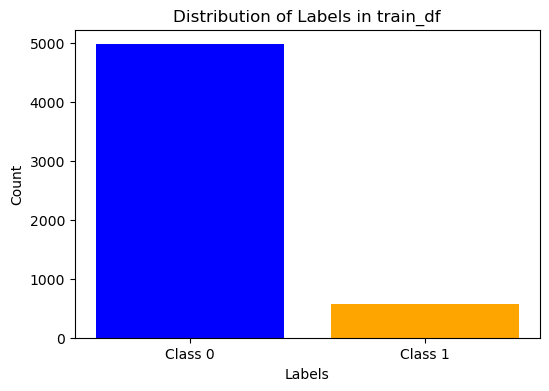

In [104]:
label_counts = newest_set.predicted_label.value_counts()
plt.figure(figsize=(6, 4))
plt.bar(label_counts.index, label_counts.values, color=['blue', 'orange']) 
plt.xticks([0, 1], ['Class 0', 'Class 1']) 
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels in train_df')
plt.show()


2. Interesting, this time there is a huge difference between the classes, where class 0 is insanely dominant. Is this how it's supposed to be(is this dataset imballanced, is it different than the previous), or is it one huge flop of the model, which worried me from the first test(that in the previous training and testing images the images are perfectly distributed, easy to spot and that made the model look more for easy simple features). Maybe the train and test sets were so close to each other(similar images) and that is why the new v2 test set was uploaded, so that it works on completely different images, which are not evenly distributed and obvious as the first one. As this is data from a competition, there are no truth labels to know whether it's like that or not. 

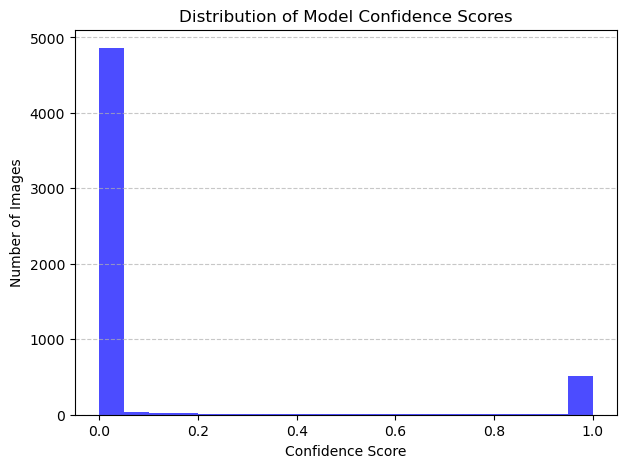

In [106]:
plt.figure(figsize=(7, 5))
plt.hist(newest_set["confidence"], bins=20, color="blue", alpha=0.7)
plt.xlabel("Confidence Score")
plt.ylabel("Number of Images")
plt.title("Distribution of Model Confidence Scores")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

#### **Image visualisation**

1. Reusing the function from previous set I will plot images to see what happens

In [ ]:
# Load a different test set
csv_file = "model_predictions_v2_new.csv"  
image_folder = "test_data_v2"

df_unl = pd.read_csv(csv_file)

# Select images for each class
num_images = 5
class_1_df = df_unl[df_unl["predicted_label"] == 1].sample(num_images, random_state=42)
class_0_df = df_unl[df_unl["predicted_label"] == 0].sample(num_images, random_state=42)

# Display images
plot_images_cf(class_1_df, f"Test Set 2: Random {num_images} Images Predicted as Class 1", image_folder, num_images)
plot_images_cf(class_0_df, f"Test Set 2: Random {num_images} Images Predicted as Class 0", image_folder, num_images)


In [ ]:
confidence_ranges = [(0.1, 0.2), (0.2, 0.3), (0.3, 0.4), (0.4, 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, 0.9)]
plot_uncertain_images_by_ranges(df_unl, confidence_ranges, num_images=20, image_folder=image_folder, title_prefix="Test Set 2: Uncertain Predictions")


#### **Evaluation of images**
After looking at the images, I can see that on most images it does well, especially if it's very confident(but even then there are 1-2 mistakes, which is not entirely bad). On images it's not so certain about it mixes them up. The errors are not complete, it still differentiates between real and ai images most of the times. But this means nothing just said like that so let's see what the model looks for when making decision

#### **Grad cam** 
I will use grad cam to see what the model makes decisions on.

In [ ]:
if __name__ == "__main__":
    # Configuration
    csv_file = "model_predictions_v2_new.csv"  # Path to the CSV file
    image_folder = "test_data_v2"  # Path to the folder containing test images
    checkpoint_path = "best_convnext_zero.pth"  # Path to the trained model checkpoint

    # Load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
    num_features = model.classifier[2].in_features
    model.classifier[2] = nn.Linear(num_features, 1)  # Binary classification
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)

    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()  # Set to evaluation mode
   
    # Transformations for preprocessing
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Plot Grad-CAM for N-number random images from the CSV
    plot_grad_cam_from_csv(
        csv_file=csv_file,
        image_folder=image_folder,
        model=model,
        num_images=5,
        transform=transform,
        confidence_range=(0.7, 0.8),  # Only process images with confidence between 50-60%
        random_state=55
    )


#### **Evaluation of grad cam**
2. The model does indeed look at relevant places to make the decisions, again sometimes it looks in the upper parts of the images(but in some cases it's logical as it can easily be seen that the light is extremely over-exposed - fitness girl image)
3. This does give hope that the model is indeed looking for logical places for clues, but it missclassifies some of them still, meaning it doesn't generalize it well, it captures important things, but cannot differentiate them , because of the lack of variability in the data.

#### **Image visualisation multy grad cam**

In [ ]:
if __name__ == "__main__":
    # Configuration
    csv_file = "model_predictions_v2_new.csv"  # Path to the CSV file
    image_folder = "test_data_v2"  # Path to the folder containing test images
    checkpoint_path = "best_convnext_zero.pth"  # Path to the trained model checkpoint

    # Load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
    num_features = model.classifier[2].in_features
    model.classifier[2] = nn.Linear(num_features, 1)  # Binary classification
    model.load_state_dict(torch.load(checkpoint_path, map_location=device, weights_only= True)["model_state_dict"])
    model = model.to(device).eval()

    # Specify layers for Grad-CAM
    layers = {
        "Layer 1 (Early)": model.features[0],  # First block
        "Layer 2 (Mid)": model.features[3],   # Middle block
        "Layer 3 (Late)": model.features[-1]  # Last block
    }

    # Transformations for preprocessing
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Plot Multi-Layer Grad-CAM for random images from the CSV
    plot_multi_layer_grad_cam_from_csv(
        csv_file=csv_file,
        image_folder=image_folder,
        model=model,
        layers=layers,
        num_images=5,
        transform=transform,
        confidence_range=(0.2, 0.3),  
        random_state=55
    )



#### **Evaluation of grad cam**
The multi-layer grad-cam does indeed look at some textures and objects in the early layers and then decides based on logical features, in some images it does indeed look at spots in the upper corner, but for the fitness girl image it makes sense. In most cases it searches in the right spots, there is no easy way to evaluate it's work with metrics as there arent any ground truths

## **Manual(very limited evaluation)**

1. I ran the script for manually labelling images. This is not the best practice as it can be thought that my labelling would be biased if i already have seen some of the images and what it predicts. But the script gives me totally random images, I don't pick out any one that I want. Also this time the choices weren't only made by me so that it's not that biased, I asked 2 of my friends to help me out with choosing and the choices are totally based on our opinions. Also I am given only the choice to say if it's random or not. Most of the images I haven't seen and most of them even made it hard for me (and other 2 people that were in the room with me at that time) to decide if it's real or not.
2. Interesting enough most images we labelled were indeed in label 0, but this could be biased (we can be wrong and the sample size based on all 5500 images is not big enough for the taks).
3. I will not run the model again I will just compare my prediciton csv and the predictions from the model to assess some performance. But without all ground truth labels I cannot say for sure how the model does. I
4. The Grad-cams show room for improvement but also show the model looking at relevant spots and making good decisions, but I want to see how it performs on some data me and 2 friends labelled(we are not professionals it's just done so that there is more than 1 person so bias is not so big).
5. And to be honest there are some things that confuse even us in the images, and compared to the previous test sets this one shows much more variability and that proves my point that the previous data that i trained and tested on is just too similar, too obvious and perfectly seperated. The model needs to be trained on more and different images, be more regularised so that it focuses on more specific spots
6. 700 images were manually labelled, so now let's see what my predictions and the model predictions are

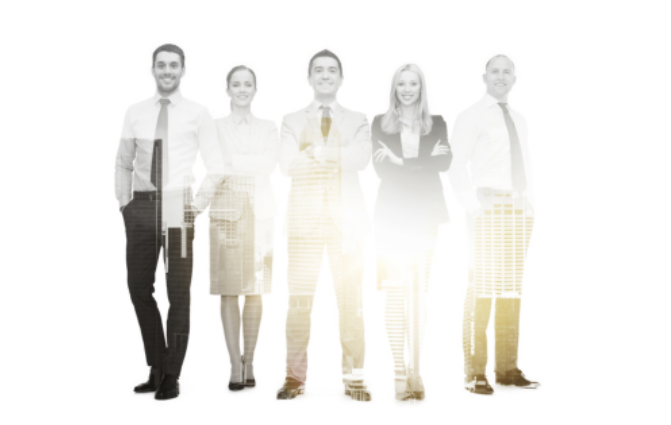  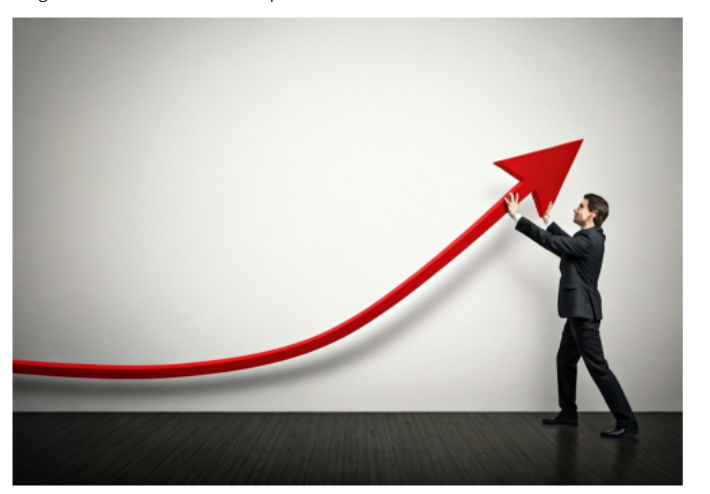 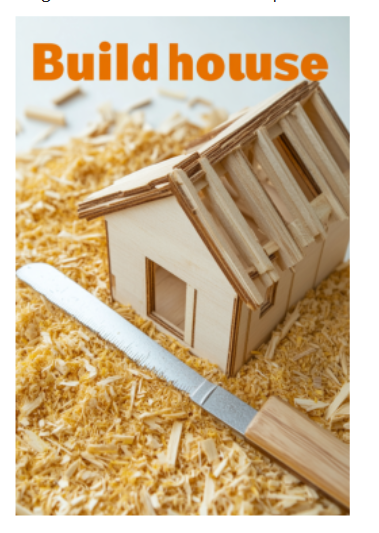 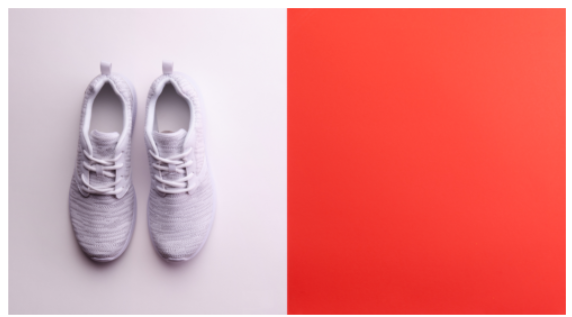 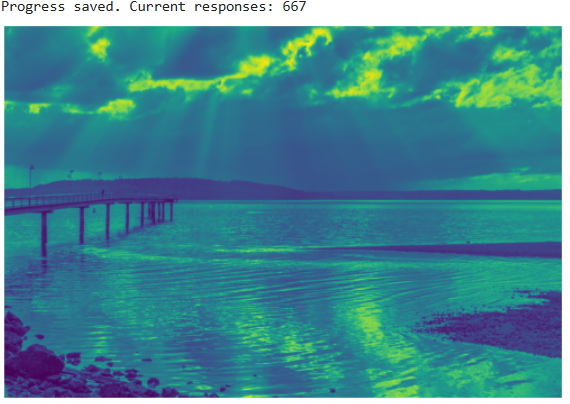

6. Let's see how it does on the labelled data and see what it did

In [108]:
my_predictions = pd.read_csv("responses_v2.csv")

In [110]:
my_predictions.label.value_counts()

label
0    554
1    146
Name: count, dtype: int64

7. As I said, most of the images me and my friends labelled as REAL, but even then we can be totally wrong

In [ ]:
# ---- CONFIG ----
manual_labels_file = "responses_v2.csv"  # Your manually labeled CSV
model_predictions_file = "model_predictions_v2_new.csv"  # Model's predictions CSV
image_folder = "test_data_v2"  # Folder containing images
num_misclassified_to_display = 20  # How many misclassified images to show

# ---- LOAD DATA ----
# Read both CSV files
manual_df = pd.read_csv(manual_labels_file)
model_df = pd.read_csv(model_predictions_file)

# Ensure column names are correct
manual_df.rename(columns={'label': 'true_label'}, inplace=True)
model_df.rename(columns={'predicted_label': 'model_prediction'}, inplace=True)

# Merge both datasets on file_name
merged_df = pd.merge(manual_df, model_df, on="file_name")

# Ensure labels are integers (0 or 1)
merged_df["true_label"] = merged_df["true_label"].astype(int)
merged_df["model_prediction"] = merged_df["model_prediction"].astype(int)

# ---- COMPUTE METRICS ----
accuracy = accuracy_score(merged_df["true_label"], merged_df["model_prediction"])
precision = precision_score(merged_df["true_label"], merged_df["model_prediction"])
recall = recall_score(merged_df["true_label"], merged_df["model_prediction"])
f1 = f1_score(merged_df["true_label"], merged_df["model_prediction"])

# Print results
print("Model Performance Compared to Manual Labels:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# ---- CONFUSION MATRIX ----
conf_matrix = confusion_matrix(merged_df["true_label"], merged_df["model_prediction"])

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Class 0", "Class 1"],
            yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ---- IDENTIFY MISCLASSIFIED IMAGES ----
misclassified = merged_df[merged_df["true_label"] != merged_df["model_prediction"]]

print("\n**Misclassified Images:**")
print(misclassified[["file_name", "true_label", "model_prediction", "confidence"]].head(20))  # Show first 20 misclassified

# ---- DISPLAY MISCLASSIFIED IMAGES ----
def plot_misclassified_images(misclassified_df, image_folder, num_images):
    """Plots misclassified images with true label and model prediction, arranging 3 images per row."""
    num_images = min(num_images, len(misclassified_df))  # Limit to available images
    if num_images == 0:
        print("No misclassified images to display.")
        return

    cols = 3  # Set 3 images per row
    rows = (num_images // cols) + (num_images % cols > 0)  # Calculate needed rows
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))

    # Flatten axes array for easy iteration
    axes = axes.flatten()

    sampled_misclassified = misclassified_df.sample(num_images, random_state=42)

    for ax, (_, row) in zip(axes, sampled_misclassified.iterrows()):
        image_path = os.path.join(image_folder, row["file_name"])
        if os.path.exists(image_path):
            image = Image.open(image_path)
            ax.imshow(image)
            ax.axis("off")
            ax.set_title(f"True: {row['true_label']} | Pred: {row['model_prediction']} | Conf: {row['confidence']:.2}")
        else:
            ax.set_title(f"Image not found: {row['file_name']}")
            ax.axis("off")

    # Hide any unused subplot axes
    for ax in axes[len(sampled_misclassified):]:
        ax.axis("off")

    plt.suptitle("Misclassified Images", fontsize=16)
    plt.tight_layout()
    plt.show()

# Plot misclassified images
plot_misclassified_images(misclassified, image_folder, num_misclassified_to_display)


#### **Results**
Based on the analysis of the manually labeled subset of 700 images, the model achieved an accuracy of 86.57%, with a precision of 84.21% and an F1-score of 57.66%. However, the recall was significantly lower at 43.84%, indicating that while the model is good at correctly predicting images as real (high precision), it struggles to identify fake images, missing a significant portion of them. This aligns with the confusion matrix, which shows that out of the 146 manually labeled fake images, the model only identified 64 correctly while misclassifying 82 as real. Meanwhile, it performed well in identifying real images, with only 12 misclassified as fake out of 554 labeled real images.

Additionally, the model was run on the entire dataset of 5,500 images, where it predicted 4,975 as real and only 565 as fake. Since the dataset is mostly unlabelled, we cannot confirm whether these predictions are accurate. However, based on the labeled subset, it appears the model is biased towards predicting images as real, which is reflected in the low recall score. This suggests that the model might be underestimating the number of fake images in the dataset. This is something that needs to be worked on further.

## **Limitations**

The model demonstrates strong performance on the initial test set, suggesting that it learned key features distinguishing real from fake images. However, its performance on the more diverse second test set (Test_v2) revealed notable limitations. One major issue is bias towards real images, as reflected in the low recall—the model frequently misclassifies fake images as real. Additionally, the model's over-reliance on specific patterns suggests possible overfitting to the first test set, which may have been too similar to the training set, leading to artificially high initial performance. One possible explanation is that the training data did not provide enough diverse examples of AI-generated images, causing the model to struggle with variations present in the second test set

Another key limitation is the failure of explainability techniques like Grad-CAM to fully capture decision-making flaws. While the Grad-CAM visualizations show that the model attends to logical image regions, such as faces and textures, it still misclassifies fake images as real. This indicates that the extracted features are not discriminative enough—the model may be focusing on the correct regions but still misinterpreting the information due to insufficient representation of fake-image artifacts in the training data.

Another factor contributing to misclassification is threshold sensitivity, as a static decision threshold (e.g., 0.5) may not be optimal for separating real and fake images. Some fake images with near-threshold confidence scores may still be classified as real, reducing recall. Improving confidence calibration or adopting adaptive thresholding could improve classification performance. Additionally, data augmentation and regularization techniques used during training may not have introduced enough variability, making the model less robust to different distortions, lighting conditions, or manipulations. Stronger regularization techniques, such as dropout or weight decay, could help mitigate this issue.

The model’s inability to generalize well to a more diverse dataset suggests that its training process lacked sufficient variety in fake images, making it less robust to new generation techniques, styles, and manipulations.

Overall, while the model is effective in many cases, its tendency to underestimate the number of fake images and overfit to the initial dataset highlights the need for further refinement. Future improvements should focus on dataset balancing, threshold optimization, enhanced feature extraction, and better confidence calibration to ensure more reliable performance across a wide range of real and AI-generated images.

## **Future work**
To enhance the model’s reliability and generalization, future work should focus on expanding and diversifying the dataset, particularly by incorporating a wider range of AI-generated images from different models, styles, and resolutions. This would mitigate the bias towards real images and improve the model’s ability to correctly identify fake images. Additionally, hard negative mining—selecting particularly challenging fake samples—can help the model learn more discriminative features, reducing misclassifications.

Another crucial area of improvement is threshold optimization and confidence calibration. Currently, the model’s fixed classification threshold (e.g., 0.5) may not be optimal for distinguishing between real and fake images, leading to high-confidence misclassifications. Implementing adaptive thresholding based on confidence distributions or calibrating confidence scores with techniques like Platt scaling or isotonic regression could refine decision-making.

Moreover, architectural advancements could further improve performance. Exploring larger or more advanced deep learning models, such as Vision Transformers (ViTs), other more powerful ConvNeXt or even Efficientnet's may provide better feature extraction capabilities. Additionally, integrating self-supervised learning could allow the model to learn richer representations from unlabeled data, reducing reliance on large manually labeled datasets.

To further address explainability, improvements in Grad-CAM or alternative interpretability methods (e.g., SHAP, LIME, or attention-based heatmaps) could provide deeper insights into why the model misclassifies certain images. This would help in debugging errors and refining training strategies.

By addressing these aspects—dataset augmentation, confidence calibration, architectural improvements, explainability enhancements, —future iterations of the model can achieve higher accuracy, better generalization, and improved trustworthiness in detecting AI-generated images.

## **Conclusion**

This study explored the effectiveness of deep learning models in distinguishing real images from AI-generated ones , but also revealed significant challenges in model generalization. Different models were tested, including ResNet50, EfficientNet-b0 and ConvNeXt-tiny. Based on metrics and generalisation ConvNeXt was the choice for the task.While the model performed well on the initial test set, its performance on a more diverse and challenging dataset (Test Set v2) revealed notable generalization issues. The model exhibited a bias toward real images, achieving high precision but low recall, meaning it correctly identified real images but frequently misclassified AI-generated ones. Explainability techniques such as Grad-CAM showed that the model attends to logical regions within images, but this did not always translate into correct predictions, indicating that its learned features might not be sufficiently discriminative.

A key challenge in this task is the rapid evolution of generative models, making it increasingly difficult to detect AI-generated images. The results suggest that dataset composition and diversity play a critical role in model performance. The model struggled with a more diverse test dataset, highlighting the need for more robust training strategies. Key limitations include the reliance on a relatively controlled dataset and the lack of adversarial robustness testing. Future improvements should focus on refining decision thresholds, improving dataset representation, and incorporating more advanced deep learning architectures to enhance performance. Additionally, confidence calibration techniques could help reduce misclassification risks.

Despite its challenges, the model provides a foundation for AI-generated image detection, and with further refinements—such as enhanced dataset curation, adaptive thresholding, and advanced feature extraction techniques—it has the potential to become a more reliable tool in the ongoing battle against AI-generated misinformation. Addressing these challenges will require continuous adaptation to stay ahead of generative advancements, ensuring that detection systems remain effective and trustworthy in an evolving landscape.

## **References**

[1] Stephan Bohm, S., CAEBUS Center of Advanced E-Business Studies, & RheinMain University of Applied Sciences. (n.d.). HumanPerception and Classification of AI-Generated Images: APre-Study based on a sample from the media sector in Germany. In ThinkMind [Research paper]. The First International Conference on Generative Pre-trained Transformer Models and Beyond, Wiesbaden, Germany. https://www.thinkmind.org/articles/gptmb_2024_1_20_38004.pdf 

[2] Goodfellow, I. J., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., Courville, A., & Bengio, Y. (2014, June 10). Generative adversarial networks. arXiv.org. https://arxiv.org/abs/1406.2661

[3] Rombach, R., Blattmann, A., Lorenz, D., Esser, P., & Ommer, B. (2021, December 20). High-Resolution Image Synthesis with Latent Diffusion Models. arXiv.org. https://arxiv.org/abs/2112.10752

[4] Van Waning, J. (2024). Human Art vs AI Art, a Potential Danger for Artist? : Artistic and Economic Evaluations across Multiple Art Genres. In B. Liefooghe, Social, Health and Organizational Psychology. https://studenttheses.uu.nl/bitstream/handle/20.500.12932/47294/Thesis_JoA%cc%83%c2%ablvanWaning%202.pdf?sequence=1&isAllowed=y

[5] Kamali, N., Nakamura, K., Chatzimparmpas, A., Hullman, J., & Groh, M. (2024, June 12). How to Distinguish AI-Generated Images from Authentic Photographs. arXiv.org. https://arxiv.org/abs/2406.08651

[6] Bird, J. J., & Lotfi, A. (2023, March 24). CIFAKE: Image Classification and Explainable Identification of AI-Generated Synthetic Images. arXiv.org. https://arxiv.org/abs/2303.14126

[7] Ediboglu Bartos, G., & Akyol, S. (4 C.E.). Deep learning for image authentication [Alba Regia Technical Faculty Obuda University]. https://www.researchgate.net/publication/375952278_Deep_Learning_for_Image_Authentication_A_Comparative_Study_on_Real_and_AI-Generated_Image_Classification

[8] He, K., Zhang, X., Ren, S., & Sun, J. (2015, December 10). Deep residual learning for image recognition. arXiv.org. https://arxiv.org/abs/1512.03385

[9] O’Shea, K., & Nash, R. (2015, November 26). An introduction to convolutional neural networks. arXiv.org. https://arxiv.org/abs/1511.08458

[10] Maruthiram, B., Venkataramireddy, .G. Venkataramireddy, & Klick, M. K. (2024). Real VS AI Generated Image Detection and  Classification. International Journal of Innovative Research in Technology (IJIRT), 11(2), ISSN: 2349-6002. https://ijirt.org/publishedpaper/IJIRT166462_PAPER.pdf

[11] Kingma, D. P., & Welling, M. (2013, December 20). Auto-Encoding variational Bayes. arXiv.org. https://arxiv.org/abs/1312.6114

[12] Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., Dehghani, M., Minderer, M., Heigold, G., Gelly, S., Uszkoreit, J., & Houlsby, N. (2020, October 22). An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale. arXiv.org. https://arxiv.org/abs/2010.11929

[13] Selvaraju, R. R., Cogswell, M., Das, A., Vedantam, R., Parikh, D., & Batra, D. (2019). Grad-CAM: Visual Explanations from Deep Networks via Gradient-Based Localization. International Journal of Computer Vision, 128(2), 336–359. https://doi.org/10.1007/s11263-019-01228-7

[14] He, K., Zhang, X., Ren, S., & Sun, J. (2015, December 10). Deep residual learning for image recognition. arXiv.org. https://arxiv.org/abs/1512.03385

[15] Potrimba, P. (2025, January 22). What is ResNet-50? Roboflow Blog. https://blog.roboflow.com/what-is-resnet-5

[16] Tan, M., & Le, Q., V. (2019, May 28). EfficientNet: Rethinking model scaling for convolutional neural networks. arXiv.org. https://arxiv.org/abs/1905.11946

[17] Sarkar, A. (2023, December 28). Understanding EfficientNet — The most powerful CNN architecture. Medium. https://arjun-sarkar786.medium.com/understanding-efficientnet-the-most-powerful-cnn-architecture-eaeb40386fad

[18] Liu, Z., Mao, H., Wu, C., Feichtenhofer, C., Darrell, T., & Xie, S. (2022, January 10). A ConvNet for the 2020s. arXiv.org. https://arxiv.org/abs/2201.03545

[19] Erdoğan, A. (2023, April 1). ConvNEXT — Next generation of convolutional networks. Medium. https://medium.com/@atakanerdogan305/convnext-next-generation-of-convolutional-networks-325607a08c46

[20] Singh, A. (2022, March 30). ConvNext: The Return of Convolution Networks - Augmented AI - Medium. Medium. https://medium.com/augmented-startups/convnext-the-return-of-convolution-networks-e70cbe8dabcc

[21] Image from: https://www.researchgate.net/figure/The-architecture-of-ConvNeXt-Tiny_fig3_372021045

[22] Image from: https://www.researchgate.net/figure/Comparison-of-the-ReLu-and-GeLu-activation-functions-ReLu-is-simpler-to-compute-but_fig3_370116538

[23] Selvaraju, R. R., Cogswell, M., Das, A., Vedantam, R., Parikh, D., & Batra, D. (2019b). Grad-CAM: Visual Explanations from Deep Networks via Gradient-Based Localization. International Journal of Computer Vision, 128(2), 336–359. https://doi.org/10.1007/s11263-019-01228-7

[24] Li, S., Li, T., Sun, C., Yan, R., & Chen, X. (2023). Multilayer Grad-CAM: An effective tool towards explainable deep neural networks for intelligent fault diagnosis. Journal of Manufacturing Systems, 69, 20–30. https://doi.org/10.1016/j.jmsy.2023.05.0270/